# Chapter 4

## 1. Initialise the code.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 26 19:14:39 2024

@author: narain

Tested in Python 3.10

Predict O2 using architectural and perfusion metrics.
"""

'\nCreated on Mon Feb 26 19:14:39 2024\n\n@author: narain\n\nTested in Python 3.10\n\nPredict O2 using architectural and perfusion metrics.\n'

Import the required libraries and set up the plotting

In [2]:
# =============================================================================
# LIBRARIES & INITIALISATION
# =============================================================================

# Import basic libraries
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
# import os
import pandas as pd
import seaborn as sns
from pathlib import Path

# For machine learning and stats
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

# Set LaTex-style font
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.size': 22})
sns.set(font='STIXGeneral', font_scale=1.7)

# Import custom functions
from get_paraview_data import *
from calculate_surviving_fraction import *
from convert_oxygen_units import *

## 2. Set up and clean the datasets.

Here, we enter the basic simulation details.

In [3]:
# Enter the details of the simulation data to analyse
solver_list = ['Constant', 'Pries', 'Memory', 'Fung']
solver_name = solver_list[2]
main_folder_path = '/Users/vedang/Documents/GitHub/dphil-scripts/demo_datasets/'
seed_selection = 60  # Voronoi
vessel_length = 85  # honeycomb

Now we pick which network we want.

In [19]:
# Choose a Voronoi folder
max_layout = 1000  # we want our dataset to be 'square': the number of initial networks (kills=0) equals the number of modified/pruned networks (kills>0) plus an extra for a demo 
simulation_path = main_folder_path + 'vor_size'
imported_raw_df = pd.read_hdf(simulation_path + '/raw_voronoi_size.h5', key='df')
# simulation_path = main_folder_path + 'vor_flow'
# imported_raw_df = pd.read_hdf(simulation_path + '/raw_voronoi_flow.h5', key='df')
# imported_raw_df = pd.read_hdf('/Users/vedang/Downloads/raw_voronoi_size_pries.h5', key='df')

# Choose a honeycomb folder
# max_layout = 100 
# simulation_path = main_folder_path + 'hex_size'
# imported_raw_df = pd.read_hdf(simulation_path + '/raw_hex_size.h5', key='df')
# simulation_path = main_folder_path + 'hex_flow'
# imported_raw_df = pd.read_hdf(simulation_path + '/raw_hex_flow.h5', key='df')

# Describe the dataset
print("Total networks: ",imported_raw_df.shape[0])
print("Total number of features (as number of columns): ", imported_raw_df.shape[1])
figure_folder = simulation_path + '/analysis/o2/'

#Check for null values
null_values = imported_raw_df.isnull().values.any()
if null_values == True:
    print("There are some missing values in imported_raw_df")
else:
    print("There are no missing values in the imported_raw_df dataset")

# Filter the dataframe as needed
raw_df = imported_raw_df
raw_df = raw_df[raw_df['selection'] <= max_layout]
raw_df['components/vessel'] = raw_df['n_connected_components'] / raw_df['n_vessels']
# raw_df['components/vessel'] = raw_df['resistance/loop']
raw_df = raw_df[raw_df['max_O2'] > 0]
# raw_df = raw_df[raw_df['mu'] == 22.76] 
# raw_df = raw_df[raw_df['sigma'] == 8.68] 
# raw_df = raw_df[raw_df['kills'] <= 1]
# raw_df[(raw_df['sigma'] == 13.23) & (raw_df['mu'] == 28.5) & (raw_df['kills'] == 0)]['PPV'].mean()
# raw_df[raw_df['kills'] == 0]['PPV'].mean()  # Ensure that the unpruned network is half-perfused
print('The intial PF is: ', raw_df[raw_df['kills'] == 0]['PPV'].mean())
print('The average initial mean_O2 is: ', convert_nM_to_mmHg(raw_df[raw_df['kills'] == 0]['50_O2'].mean()))

Total networks:  40863
Total number of features (as number of columns):  38
There are no missing values in the imported_raw_df dataset
The intial PF is:  0.4792412856900932
The average initial mean_O2 is:  8.676070679116767


/var/folders/kk/4sq3dnmd7vv_h0__c5z06_cw0000gn/T/ipykernel_73367/2127691202.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['components/vessel'] = raw_df['n_connected_components'] / raw_df['n_vessels']


Cancelled: Round the quantities to experimental standards. This makes no sense and leads to striations in prediction graph.

In [20]:
# Round the quantities to experimental standards
# raw_df['NF'] = (raw_df['NF']).round(2)
# raw_df['FCD'] = (raw_df['FCD']*1000).round(1)  
# raw_df['VDi'] = (raw_df['VDi']*1000).round(1)
# raw_df['PPV'] = (raw_df['PPV']*100).round(0)

Check if any simulations begin with a very low NF or more than one connected component.

In [52]:
# Warn if any simulations begin with a very low NF
low_nf_df = raw_df[(raw_df['NF'] < 0.1) & (raw_df['kills'] < 10)]
for index, row in low_nf_df.iterrows():
    print(f"WARNING: NF<0.1 in: selection {row['selection']}, kills {row['kills']}")

# Warn if any simulations begin with more than one connected component
multicomponent_df = raw_df[(raw_df['n_connected_components'] > 1) & (raw_df['kills'] == 0)]
for index, row in multicomponent_df.iterrows():
    print(f"WARNING: n_connected_components>1 in: selection {row['selection']}, kills {row['kills']}")

In [58]:
raw_df['wouters_SF'].var()

0.001570548858476625

In [59]:
raw_df['wouters_SF'].mean()

0.6205046655953024

In [49]:
zazu = raw_df[(raw_df['kills'] == 0)]

## 3. Check the changes in NF as networks are pruned (for RT study)

### 3.a. Voronoi

Plot all the networks.

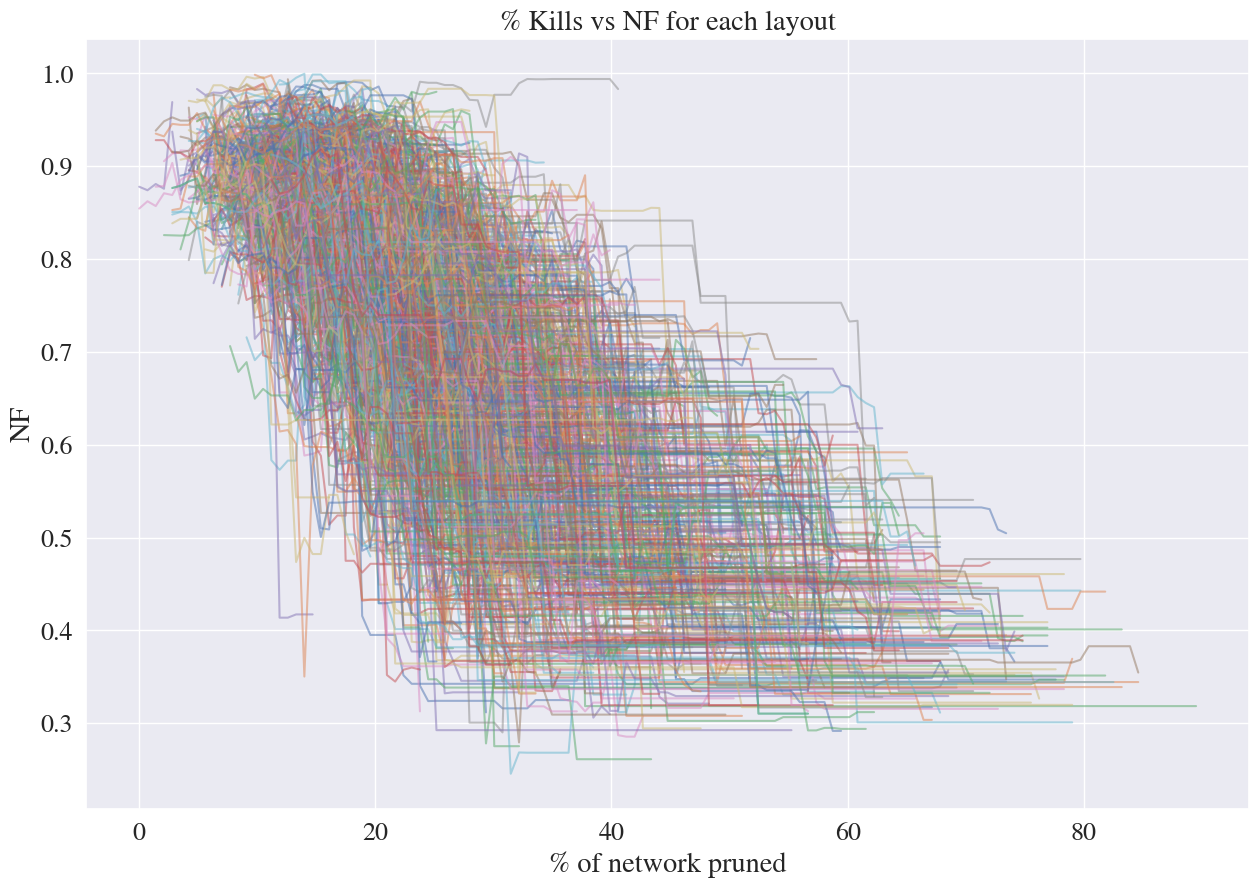

In [23]:
# Plot the selections
plt.figure(figsize=(15, 10))
selections = raw_df['selection'].unique()
raw_df['kills_perc'] = ((raw_df['n_vessels'].max() - raw_df['n_vessels']) / raw_df['n_vessels'].max()) * 100
for selection in selections:
    subset = raw_df[raw_df['selection'] == selection]
    # kills_perc = ((subset['n_vessels'].max()-subset['n_vessels'])/subset['n_vessels'].max())*100
    plt.plot(subset['kills_perc'], subset['NF'], alpha=0.5)  # Adjusted alpha for translucency
    # plt.plot(subset['kills'], subset['NF'], alpha=0.5)  # Adjusted alpha for translucency
plt.xlabel('% of network pruned')
plt.ylabel('NF')
plt.title('% Kills vs NF for each layout')
plt.grid(True)
plt.show()

Compute the number of simulations in which the NF improves.

In [24]:
# Compute the number of simulations in which NF improves
initial_nf = raw_df[raw_df['kills'] == 0][['selection', 'NF']].rename(columns={'NF': 'initial_NF'})  # determine the initial NF value at kills=0 for each selection
merged_df = raw_df.join(initial_nf.set_index('selection'), on='selection')  # merge this back into the original dataframe
merged_df['Improvement'] = merged_df['NF'] - merged_df['initial_NF']  # calculate the improvement
kills_gt_zero_df = merged_df
# kills_gt_zero_df['Improvement'] = kills_gt_zero_df.groupby('selection')['NF'].diff()
kills_gt_zero_df = kills_gt_zero_df[kills_gt_zero_df['kills'] > 0]  # filter for kills > 0 to remove NaN values
max_improvement_df = kills_gt_zero_df.groupby('selection')['Improvement'].max().reset_index()  # find the maximum improvement for each selection
print('% of networks in which NF improves (non-monotonic NF): ', 100 * len(max_improvement_df[max_improvement_df['Improvement'] > 0]) / len(max_improvement_df))  # calculate percentage of selections that show improvement

# Filter for positive NF changes
positive_changes = merged_df[merged_df['Improvement'] > 0]

# Calculate the total number of unique selections
num_unique_selections = positive_changes['selection'].nunique()

# Calculate the average maximum improvement across all unique combinations
average_max_improvement = max_improvement_df['Improvement'].mean()

# Print the average maximum improvement
print(f'Average maximum NF improvement across networks: {average_max_improvement:.4f}')

% of networks in which NF improves (non-monotonic NF):  73.21965897693079
Average maximum NF improvement across networks: 0.0192


Save some data for the rainbow plots.

In [25]:
vs = positive_changes
# vf = positive_changes
max_improvement_df_vs = max_improvement_df
# max_improvement_df_vf = max_improvement_df

Plot the KDE of positive NF changes.

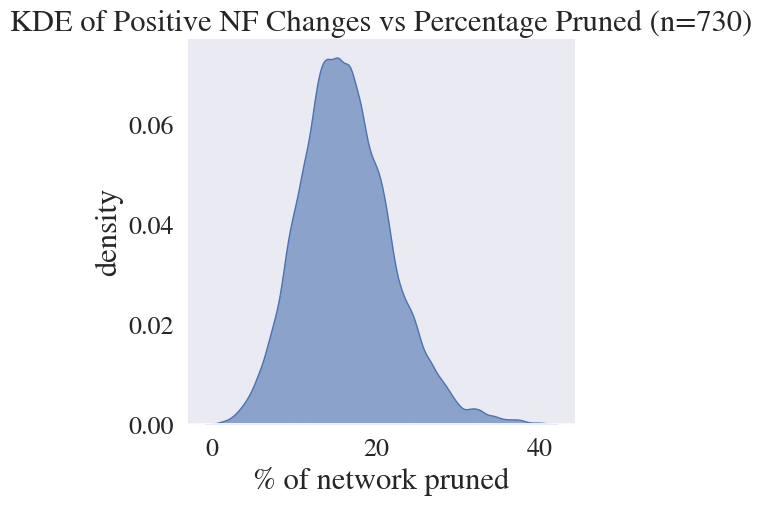

In [26]:
# Plot the KDE of positive NF changes against the percentage pruned
plt.figure(figsize=(5, 5))
sns.kdeplot(data=positive_changes, x='kills_perc', bw_adjust=0.5, fill=True, alpha=0.6, color='C0')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('% of network pruned', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.ylabel('density', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.title(f'KDE of Positive NF Changes vs Percentage Pruned (n={num_unique_selections})', fontdict={'family': 'STIXGeneral', 'size': 22})

# Remove grid lines and adjust spines
ax = plt.gca()
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show the plot
figure_title = 'kde_positive_nf_changes_vs_pruned'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()


# # =============================================================================
# # PLOT THE NUMBER OF SELECTIONS WITH POSITIVE NF VALUES AGAINST PERCENTAGE PRUNED
# # =============================================================================

# import matplotlib.pyplot as plt
# import pandas as pd

# # Ensure LaTeX-style font globally
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams.update({'font.size': 22})

# # Compute the percentage pruned and the NF change for each percentage
# raw_df['kills_perc'] = ((raw_df['n_vessels'].max() - raw_df['n_vessels']) / raw_df['n_vessels'].max()) * 100
# initial_nf = raw_df[raw_df['kills'] == 0][['selection', 'NF']].rename(columns={'NF': 'initial_NF'})
# merged_df = raw_df.join(initial_nf.set_index('selection'), on='selection')
# merged_df['NF_change'] = merged_df['NF'] - merged_df['initial_NF']

# # Count the number of selections with positive NF values at each pruning percentage
# positive_counts = merged_df[merged_df['NF_change'] > 0].groupby('kills_perc')['selection'].nunique().reset_index()
# positive_counts.rename(columns={'selection': 'count'}, inplace=True)

# # Calculate the total number of unique selections with positive NF values
# num_unique_positive_selections = merged_df[merged_df['NF_change'] > 0]['selection'].nunique()

# # Plot the counts of positive NF values against the percentage pruned
# plt.figure(figsize=(10, 6))
# plt.plot(positive_counts['kills_perc'], positive_counts['count'], lw=3, marker='o')
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# # Add labels and title
# plt.xlabel('% of network pruned', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.ylabel('Number of selections with positive NF value', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.title(f'Number of Positive NF Values vs Percentage Pruned (n={num_unique_positive_selections})', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.grid(True, linestyle='--', alpha=0.7)

# # Save and show the plot
# figure_title = 'positive_nf_values_count_vs_pruned'
# file_path = Path(figure_folder + figure_title + '.png').expanduser()
# plt.savefig(file_path, dpi=500, bbox_inches='tight')
# plt.show()


Let's take a look at which networks show the biggest improvement.

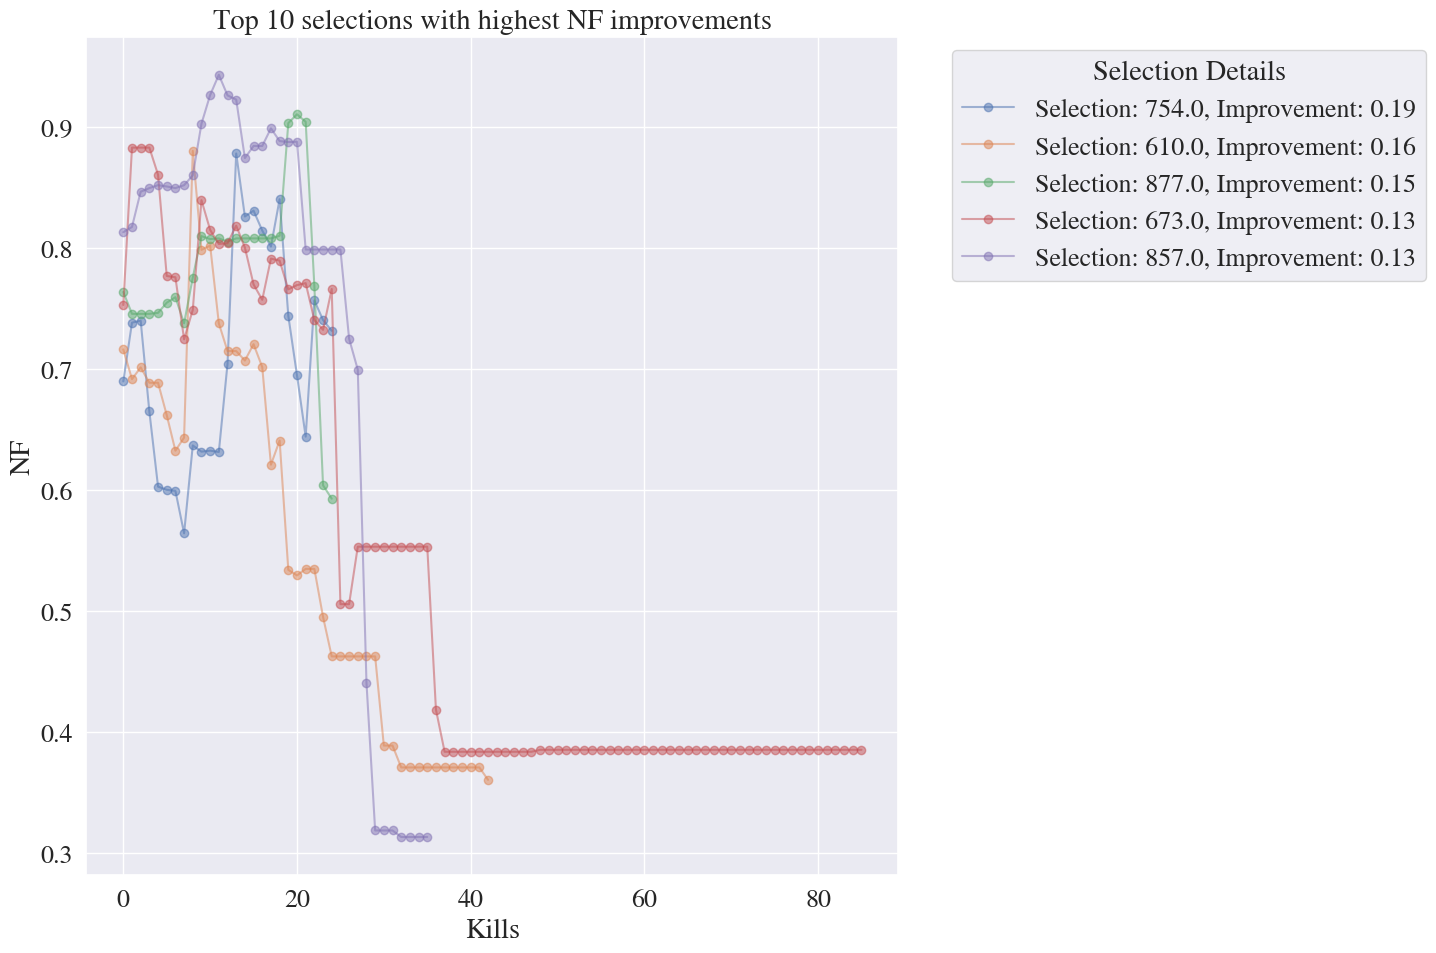

In [27]:
# Plot the top ten selections with the biggest NF improvements
sorted_df = max_improvement_df.sort_values(by='Improvement', ascending=False)  # sort the result dataframe by improvement in descending order
top_combinations = sorted_df.head(5)  # select the top 5 combinations with the highest improvements
plt.figure(figsize=(15, 10))
for index, row in top_combinations.iterrows():
    selection, improvement = row['selection'], row['Improvement']
    # Extract the data for the current selection from the original raw_df
    subset = raw_df[raw_df['selection'] == selection]
    # Plot kills vs NF
    plt.plot(subset['kills'], subset['NF'], label=f'Selection: {selection}, Improvement: {improvement:.2f}',
              marker='o', linestyle='-', alpha=0.5)  # Adjusted alpha for translucency
plt.xlabel('Kills')
plt.ylabel('NF')
plt.title('Top 10 selections with highest NF improvements')
plt.legend(title='Selection Details', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Now let's just plot one.

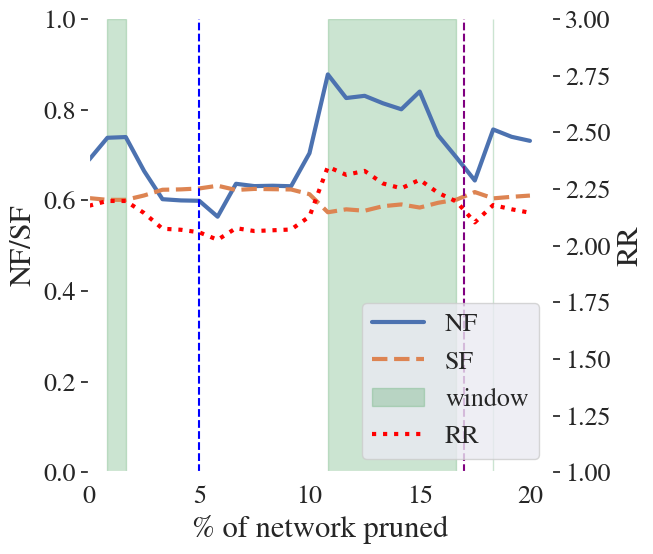

In [28]:
# Plotting the best only
fig, ax1 = plt.subplots(figsize=(7, 6))
width = 3

# Ensure LaTeX-style font globally
# sns.reset_orig()
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

# Extract the top combination
top_combinations = sorted_df.iloc[0]
selection, improvement = top_combinations['selection'], top_combinations['Improvement']
# Filter the data for this combination
subset = raw_df[raw_df['selection'] == selection]

# Compute the percentage of the network pruned
kills_perc = ((subset['n_vessels'].max() - subset['n_vessels']) / subset['n_vessels'].max()) * 100

# Plot NF
NF_line, = ax1.plot(kills_perc, subset['NF'], linestyle='-', lw=width, label='NF')

# Plot SF
woutersSF_line, = ax1.plot(kills_perc, subset['wouters_SF'], label='SF', linestyle='--', lw=width)

# Add vertical lines at x=5 and x=17
ax1.axvline(5, color='blue', linestyle='--', linewidth=1.5)
ax1.axvline(17, color='purple', linestyle='--', linewidth=1.5)

# Configure primary y-axis
ax1.set_xlabel('% of network pruned', fontdict={'family': 'STIXGeneral', 'size': 22})
ax1.set_ylabel('NF/SF', fontdict={'family': 'STIXGeneral', 'size': 22})
ax1.set_xlim(0)
ax1.set_ylim(0, 1)
ax1.set_facecolor('white')
ax1.grid(False)

# Ensure all spines are visible except the top
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['right'].set_linewidth(1.5)

# Secondary y-axis for relative ratios
ax2 = ax1.twinx()

# Compute and plot RR
wouters_rr = compute_RR(subset['wouters_SF'], anoxic_SF=calculate_array_Wouters_SF(0))
ax2.plot(kills_perc, wouters_rr, label='RR', linestyle=':', lw=width, color='red')
ax2.set_ylim(1, 3)
ax2.set_ylabel('RR', fontdict={'family': 'STIXGeneral', 'size': 22})
ax2.set_facecolor('white')
ax2.grid(False)

# Ensure all spines are visible except the top for secondary y-axis
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['right'].set_linewidth(1.5)

# Highlight intervals where wouters_rr > its initial value at x=0
initial_wouters_rr = wouters_rr.iloc[0]
above_initial = wouters_rr > initial_wouters_rr
in_interval = False
start = None

normalisation_label_added = False  # Ensure the label appears only once

for i in range(len(kills_perc)):
    if above_initial.iloc[i] and not in_interval:
        # Start a new interval
        start = kills_perc.iloc[i]
        in_interval = True
    elif not above_initial.iloc[i] and in_interval:
        # End the interval and shade it
        if not normalisation_label_added:
            ax1.axvspan(start, kills_perc.iloc[i - 1], color='g', alpha=0.3, label='window')
            normalisation_label_added = True
        else:
            ax1.axvspan(start, kills_perc.iloc[i - 1], color='g', alpha=0.3)
        in_interval = False
# Handle the case where the interval goes to the end of the data
if in_interval:
    if not normalisation_label_added:
        ax1.axvspan(start, kills_perc.iloc[-1], color='g', alpha=0.3, label='window')
    else:
        ax1.axvspan(start, kills_perc.iloc[-1], color='g', alpha=0.3)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

# Save and show the plot
plt.tight_layout()
figure_title = 'best_NF_improvement'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()


### 3.b. Honeycomb

Plot all the networks.

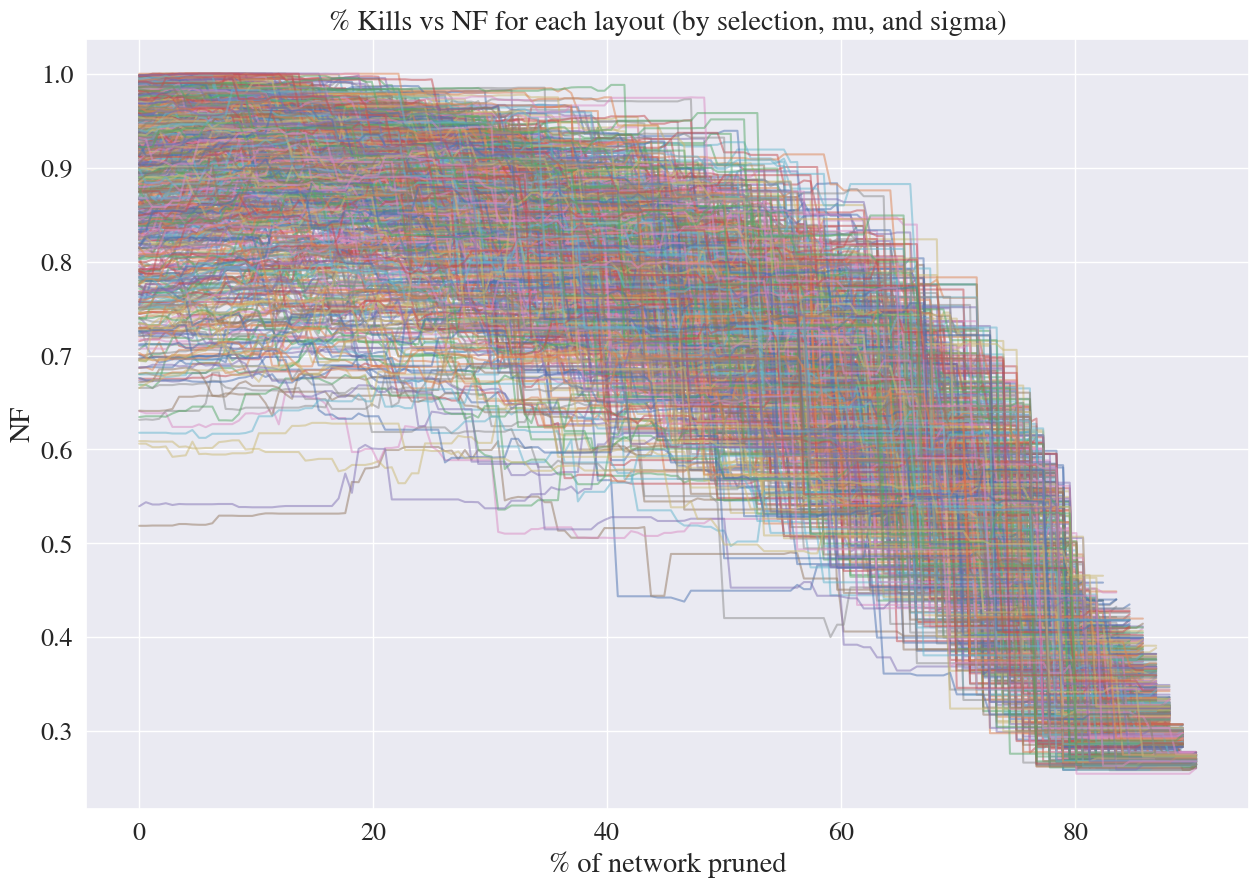

In [39]:
# Plot the selections
plt.figure(figsize=(15, 10))

# Compute the percentage of the network pruned
raw_df['kills_perc'] = ((raw_df['n_vessels'].max() - raw_df['n_vessels']) / raw_df['n_vessels'].max()) * 100

# Get all unique combinations of selection, mu, and sigma
unique_combinations = raw_df[['selection', 'mu', 'sigma']].drop_duplicates()

# Loop over each unique combination and plot
for _, row in unique_combinations.iterrows():
    selection = row['selection']
    mu = row['mu']
    sigma = row['sigma']
    
    # Filter the data for this combination
    subset = raw_df[(raw_df['selection'] == selection) & (raw_df['mu'] == mu) & (raw_df['sigma'] == sigma)]
    
    # Plot NF against percentage pruned
    plt.plot(subset['kills_perc'], subset['NF'], alpha=0.5, label=f'sel={selection}, mu={mu}, sigma={sigma}')

# Add plot labels and title
plt.xlabel('% of network pruned')
plt.ylabel('NF')
plt.title('% Kills vs NF for each layout (by selection, mu, and sigma)')
plt.grid(True)

# Add a legend if desired (can get crowded with too many combinations)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Show the plot
plt.show()

Compute the number of simulations in which the NF improves.

In [40]:
# Compute the number of simulations in which NF improves
# Determine the initial NF value at kills=0 for each combination of selection, mu, and sigma
initial_nf = raw_df[raw_df['kills'] == 0][['selection', 'mu', 'sigma', 'NF']].rename(columns={'NF': 'initial_NF'})

# Merge this back into the original dataframe
merged_df = raw_df.merge(initial_nf, on=['selection', 'mu', 'sigma'])

# Calculate the improvement
merged_df['Improvement'] = merged_df['NF'] - merged_df['initial_NF']

# Filter for kills > 0 to remove NaN values
kills_gt_zero_df = merged_df[merged_df['kills'] > 0]

# Find the maximum improvement for each unique combination of selection, mu, and sigma
max_improvement_df = kills_gt_zero_df.groupby(['selection', 'mu', 'sigma'])['Improvement'].max().reset_index()

# Calculate the percentage of unique combinations that show improvement
percentage_improved = 100 * len(max_improvement_df[max_improvement_df['Improvement'] > 0]) / len(max_improvement_df)
print(f'% of networks in which NF improves (non-monotonic NF): {percentage_improved:.2f}%')

# Filter for positive NF changes
positive_changes = merged_df[merged_df['Improvement'] > 0]

# Calculate the total number of unique combinations with positive NF changes
num_unique_combinations = positive_changes[['selection', 'mu', 'sigma']].drop_duplicates().shape[0]
print(f'Total number of unique combinations with positive NF changes: {num_unique_combinations}')

# Calculate the average maximum improvement across all unique combinations
average_max_improvement = max_improvement_df['Improvement'].mean()

# Print the average maximum improvement
print(f'Average maximum NF improvement across networks: {average_max_improvement:.4f}')


% of networks in which NF improves (non-monotonic NF): 94.89%
Total number of unique combinations with positive NF changes: 854
Average maximum NF improvement across networks: 0.0239


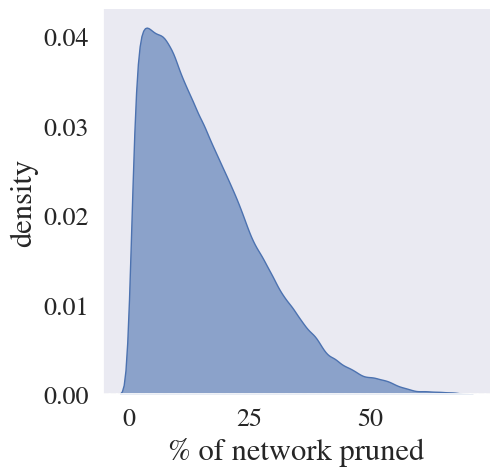

In [41]:
# Calculate the total number of unique combinations with positive NF changes
num_unique_combinations = positive_changes[['selection', 'mu', 'sigma']].drop_duplicates().shape[0]

# Plot the KDE of positive NF changes against the percentage pruned
plt.figure(figsize=(5, 5))
sns.kdeplot(data=positive_changes, x='kills_perc', bw_adjust=0.5, fill=True, alpha=0.6, color='C0')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('% of network pruned', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.ylabel('density', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.title(f'KDE of Positive NF Changes vs Percentage Pruned (n={num_unique_combinations})', fontdict={'family': 'STIXGeneral', 'size': 22})

# Remove grid lines and adjust spines
ax = plt.gca()
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show the plot
figure_title = 'kde_positive_nf_changes_vs_pruned'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()


Save some data for the rainbow plot.

In [42]:
# hs = positive_changes
hf = positive_changes
# max_improvement_df_hs = max_improvement_df
max_improvement_df_hf = max_improvement_df

Let's take a look at which networks show the biggest improvement.

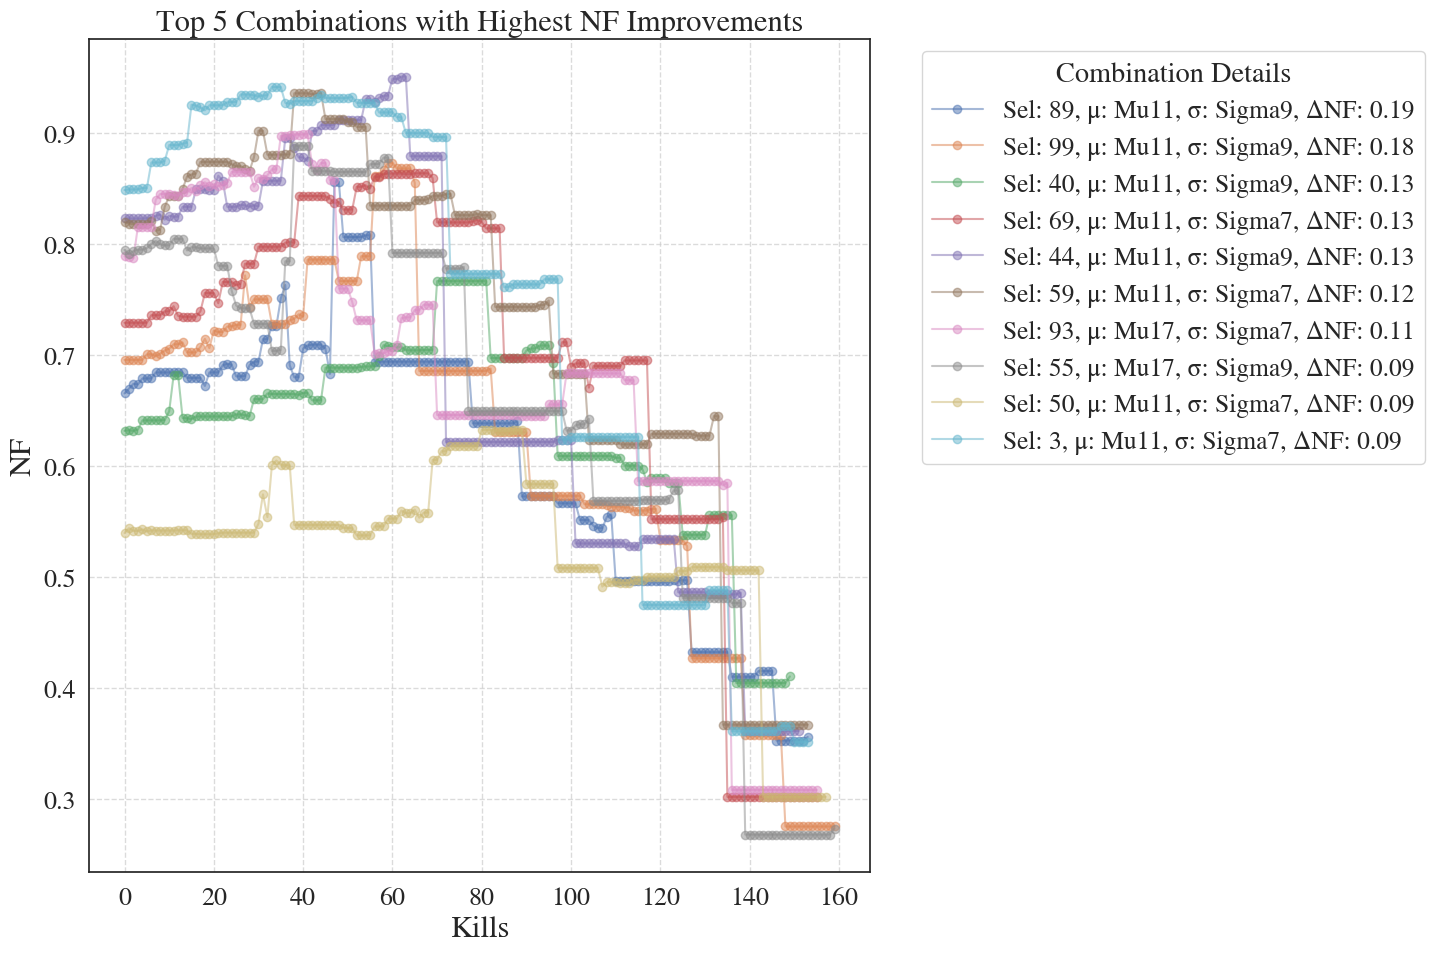

In [203]:
# Plot the top five combinations with the biggest NF improvements
sorted_df = max_improvement_df.sort_values(by='Improvement', ascending=False)  # Sort by improvement in descending order
top_combinations = sorted_df.head(10)  # Select the top 5 combinations with the highest improvements

plt.figure(figsize=(15, 10))

# Loop over each combination and plot
for index, row in top_combinations.iterrows():
    selection, mu, sigma, improvement = row['selection'], row['mu'], row['sigma'], row['Improvement']
    
    # Extract the data for the current combination
    subset = raw_df[(raw_df['selection'] == selection) & 
                    (raw_df['mu'] == mu) & 
                    (raw_df['sigma'] == sigma)]
    
    # Plot kills vs NF
    plt.plot(subset['kills'], subset['NF'], label=f'Sel: {selection}, μ: {mu}, σ: {sigma}, ΔNF: {improvement:.2f}',
             marker='o', linestyle='-', alpha=0.5)  # Adjusted alpha for translucency

# Add labels, title, and legend
plt.xlabel('Kills', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.ylabel('NF', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.title('Top 5 Combinations with Highest NF Improvements', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.legend(title='Combination Details', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


Now let's just plot one.

In [378]:
# Plotting the best only
fig, ax1 = plt.subplots(figsize=(7.5, 5))
width = 3

# Extract the top combination
top_combinations = sorted_df.iloc[2]
selection, mu, sigma, improvement = top_combinations['selection'], top_combinations['mu'], top_combinations['sigma'], top_combinations['Improvement']
# Filter the data for this combination
subset = raw_df[(raw_df['selection'] == selection) & 
                (raw_df['mu'] == mu) & 
                (raw_df['sigma'] == sigma)]

# Compute the percentage of the network pruned
kills_perc = ((subset['n_vessels'].max() - subset['n_vessels']) / subset['n_vessels'].max()) * 100

# Plot NF
NF_line, = ax1.plot(kills_perc, subset['NF'], linestyle='-', lw=width, label='NF')

# Plot SF
woutersSF_line, = ax1.plot(kills_perc, subset['wouters_SF'], label='SF', linestyle='--', lw=width)

# Configure primary y-axis
ax1.set_xlabel('% of network pruned', fontdict={'family': 'STIXGeneral', 'size': 22})
ax1.set_ylabel('NF/SF', fontdict={'family': 'STIXGeneral', 'size': 22})
ax1.set_xlim(0)
ax1.set_ylim(0, 1)
ax1.set_facecolor('white')
ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(True)

# Secondary y-axis for relative ratios
ax2 = ax1.twinx()

# Compute and plot RR
wouters_rr = compute_RR(subset['wouters_SF'], anoxic_SF=calculate_array_Wouters_SF(0))
ax2.plot(kills_perc, wouters_rr, label='RR', linestyle=':', lw=width, color='red')
ax2.set_ylim(1, 3)
ax2.set_ylabel('RR', fontdict={'family': 'STIXGeneral', 'size': 22})
ax2.set_facecolor('white')
ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(True)

# Highlight intervals where wouters_rr > its initial value at x=0
initial_wouters_rr = wouters_rr.iloc[0]
above_initial = wouters_rr > initial_wouters_rr
in_interval = False
start = None

normalisation_label_added = False  # Ensure the label appears only once

for i in range(len(kills_perc)):
    if above_initial.iloc[i] and not in_interval:
        # Start a new interval
        start = kills_perc.iloc[i]
        in_interval = True
    elif not above_initial.iloc[i] and in_interval:
        # End the interval and shade it
        if not normalisation_label_added:
            ax1.axvspan(start, kills_perc.iloc[i - 1], color='green', alpha=0.2, label='normalisation window')
            normalisation_label_added = True
        else:
            ax1.axvspan(start, kills_perc.iloc[i - 1], color='green', alpha=0.2)
        in_interval = False
# Handle the case where the interval goes to the end of the data
if in_interval:
    if not normalisation_label_added:
        ax1.axvspan(start, kills_perc.iloc[-1], color='green', alpha=0.2, label='normalisation window')
    else:
        ax1.axvspan(start, kills_perc.iloc[-1], color='green', alpha=0.2)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

# Save and show the plot
plt.tight_layout()
figure_title = 'best_NF_improvement'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()


KeyError: 'mu'

### 3.c. Rainbow plots

Plot the positive NF changes against the pruning point at which they appear.

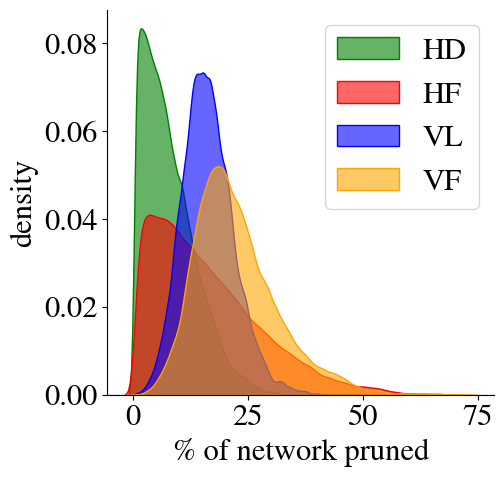

In [44]:
# Plot KDEs for vs, vf, hs, and hf on the same plot
plt.figure(figsize=(5, 5))

# Ensure LaTeX-style font globally
sns.reset_orig()
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

# Plot each variable with a different color and label
sns.kdeplot(data=hs, x='kills_perc', bw_adjust=0.5, fill=True, alpha=0.6, label='HD', color='green')
sns.kdeplot(data=hf, x='kills_perc', bw_adjust=0.5, fill=True, alpha=0.6, label='HF', color='red')
sns.kdeplot(data=vs, x='kills_perc', bw_adjust=0.5, fill=True, alpha=0.6, label='VL', color='blue')
sns.kdeplot(data=vf, x='kills_perc', bw_adjust=0.5, fill=True, alpha=0.6, label='VF', color='orange')

# Add horizontal reference line
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add labels, title, and legend
plt.xlabel('% of network pruned', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.ylabel('density', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.title('KDE of Positive NF Changes for vs, vf, hs, hf', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.legend(title='Variable', fontsize=12)
plt.legend()

# Remove grid lines and adjust spines
ax = plt.gca()
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show the plot
figure_title = 'kde_positive_nf_changes_vs_vf_hs_hf'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()


Plot the maximum NF in each network as a KDE.

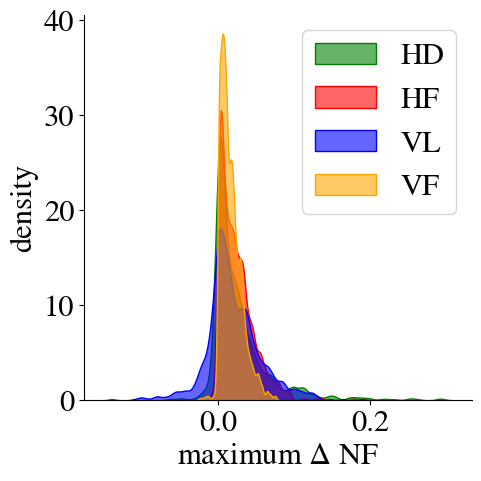

In [45]:
# Plot the KDE of positive NF changes against the percentage pruned
plt.figure(figsize=(5, 5))

# Ensure LaTeX-style font globally
sns.reset_orig()
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

# Plot each variable with a different color and label
sns.kdeplot(data=max_improvement_df_hs, x='Improvement', bw_adjust=0.5, fill=True, alpha=0.6, label='HD', color='green')
sns.kdeplot(data=max_improvement_df_hf, x='Improvement', bw_adjust=0.5, fill=True, alpha=0.6, label='HF', color='red')
sns.kdeplot(data=max_improvement_df_vs, x='Improvement', bw_adjust=0.5, fill=True, alpha=0.6, label='VL', color='blue')
sns.kdeplot(data=max_improvement_df_vf, x='Improvement', bw_adjust=0.5, fill=True, alpha=0.6, label='VF', color='orange')

# Add labels, title, and legend
plt.xlabel(r'maximum $\Delta$ NF', fontdict={'family': 'STIXGeneral', 'size': 22})
plt.ylabel('density', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.title('KDE of Positive NF Changes for vs, vf, hs, hf', fontdict={'family': 'STIXGeneral', 'size': 22})
# plt.legend(title='Variable', fontsize=12)
plt.legend()

# Remove grid lines and adjust spines
ax = plt.gca()
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show the plot
figure_title = 'kde_positive_nf_changes_vs_vf_hs_hf'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()


## 4. Feature selection using clustermap

Pick a selection for a prediction demo if needed.

In [696]:
# =============================================================================
# CREATE A DEMO SELECTION IF NEEDED
# =============================================================================
# '''
# Use the last selection for a demonstration
demo_selection = 1001

# Filter rows based on the condition
demo_dataset = raw_df[raw_df['selection'] == demo_selection]

# Remove the filtered rows from the original DataFrame
combined_df = raw_df[raw_df['selection'] != demo_selection]
# '''

Make an initial split of the dataset.

In [697]:
# =============================================================================
# SPLIT UP TRAINING AND TEST DATA
# =============================================================================

# Define feature matrix X and target variable y
X = combined_df.drop("NF", axis=1)  # Feature Matrix
Y = combined_df["NF"]  # Target Variable

# Y contains the target variables (labels)
Y = combined_df[['NF']]
# Y = Y.values.ravel()

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Record the simulations from which the test data is sourced
test_data_source = combined_df.loc[X_test.index, ['selection', 'kills']]

# Combine X_train and y_train for correlation analysis
all_train = pd.concat([X_train, Y_train], axis=1)

Drop quantities that we can't measure or are not relevant. We want the results to be normalised, i.e., scale-invariant (smaller area will have fewer vessels). We should also drop quantities that are not ascertainable experimentally.

In [698]:
# Drop rows that aren't measurable    
relevant_train = all_train.drop(columns=[
                                        'selection', 'kills',
                                        # 'closeness_unweighted_avg', 'closeness_weighted_avg', 'pagerank_weighted_avg', 
                                        # 'betweenness_weighted_avg', 'edge_betweenness_weighted_avg', 'pagerank_unweighted_avg',
                                        'h_theil', 'h_atkinson', 'h_shannon', 'h_hoover', 'h_pietra', 'h_cv', # 'h_gini', 
                                        'h_inverse_simpson', 'h_haemo_potential', 'h_std_dev',
                                        '50_O2', 'mean_O2', 'HF', 'RF', 'min_O2', 'max_O2', 'SD_O2', 'total_O2',
                                        "wouters_SF", 'lewin_SF'
                                       ])

# Drop features that are not scale-invariant
relevant_train = relevant_train.drop(columns=[
                                        'n_cycles', 'n_vessels', 'n_perfused_vessels', 'n_unperfused_vessels', 
                                        'size_largest_connected_component', 'n_connected_components', 
                                        # 'mu', 'sigma',
                                       ])

Plot the clustermap of possible candidates.

In [699]:
# Plot the clustermap with the preprocessed correlation matrix
# '''
# Function to replace specific labels
def replace_label(label):
    if label == 'components/vessel':
        return r'$\overline{\beta_0}$'
    elif label == 'loops/vessel':
        return r'$\overline{\beta_1}$'
    elif label == 'VDi':
        return 'DBS'
    elif label == 'PPV':
        return r'$\mathcal{P}$'    
    elif label == 'mean_diameter':
        return r'$\overline{d}$'
    elif label == 'pagerank_unweighted_avg':
        return r'$\overline{P}$'
    elif label == 'betweenness_weighted_avg':
        return r'$\overline{B}_w$'
    elif label == 'betweenness_unweighted_avg':
        return r'$\overline{B}$'    
    elif label == 'mean_geometric_resistance':
        return r'$\overline{R}^{geom}$'
    elif label == 'resistance/loop':
        return r'$\overline{R}_β^{geom}$'
    else:
        return label

# Plot the correlation matrix
relevantt_train = relevant_train.drop(columns=['edge_betweenness_unweighted_avg', 'resistance/loop', 'components/vessel'])  # (drop for figure)
correlation_matrix = relevantt_train.corr(min_periods=1)
#sns.set(font_scale=0.7)

# Apply the replacement to both index and columns
new_index = [replace_label(label) for label in correlation_matrix.index]
new_columns = [replace_label(label) for label in correlation_matrix.columns]

# Create a new DataFrame with the updated labels
labeled_matrix = pd.DataFrame(
    correlation_matrix.values,
    index=new_index,
    columns=new_columns
)

# Now create the clustermap with the new labels
g = sns.clustermap(
    labeled_matrix, annot=True, cmap='coolwarm', metric="euclidean", 
    method='complete', annot_kws={"fontsize": 22}, fmt=".2f", figsize=(10, 10),
    vmin=-1, vmax=1  # Set the color scale limits
)

# Rotate the tick labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=0)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
# plt.tight_layout()  # Adjust the layout to prevent cutoff

[Text(1, 0.5, '$\\overline{P}$'),
 Text(1, 1.5, '$\\overline{R}^{geom}$'),
 Text(1, 2.5, '$\\overline{B}$'),
 Text(1, 3.5, 'kills_perc'),
 Text(1, 4.5, 'DBS'),
 Text(1, 5.5, '$\\overline{\\beta_1}$'),
 Text(1, 6.5, 'NF'),
 Text(1, 7.5, '$\\overline{d}$'),
 Text(1, 8.5, 'FCD'),
 Text(1, 9.5, '$\\mathcal{P}$')]

In [700]:
cor_target = abs(correlation_matrix["NF"])
irrelevant_features = cor_target[(cor_target <= 0.65) & (cor_target >= -0.65)].index.tolist()
print(f"Poorly correlated features with target: {irrelevant_features}")

# Drop poorly-correlated features
bad_features = ['mean_diameter', 'pagerank_unweighted_avg']
possible_train = relevantt_train.drop(columns=bad_features)

Poorly correlated features with target: ['mean_diameter', 'PPV', 'VDi', 'pagerank_unweighted_avg']


Select features highly correlated with the target variable


In [701]:
# Plot the correlation matrix
# possible_train = relevant_train[relevant_features]
correlation_matrix = possible_train.corr(min_periods=1)
#sns.set(font_scale=0.7)

# Apply the replacement to both index and columns
new_index = [replace_label(label) for label in correlation_matrix.index]
new_columns = [replace_label(label) for label in correlation_matrix.columns]

# Create a new DataFrame with the updated labels
labeled_matrix = pd.DataFrame(
    correlation_matrix.values,
    index=new_index,
    columns=new_columns
)

# Now create the clustermap with the new labels
g = sns.clustermap(labeled_matrix, annot=True, cmap='coolwarm', metric="euclidean", 
                method='complete', annot_kws={"fontsize": 11}, fmt=".2f", figsize=(20, 20))
# Rotate the tick labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
# plt.tight_layout()  # Adjust the layout to prevent cutoff

[Text(1, 0.5, '$\\overline{R}^{geom}$'),
 Text(1, 1.5, '$\\overline{B}$'),
 Text(1, 2.5, 'kills_perc'),
 Text(1, 3.5, 'DBS'),
 Text(1, 4.5, '$\\overline{\\beta_1}$'),
 Text(1, 5.5, 'NF'),
 Text(1, 6.5, 'FCD'),
 Text(1, 7.5, '$\\mathcal{P}$')]

In [702]:
# Flag highly correlated pairs
correlation_matrix = possible_train.corr()
highly_correlated_pairs = correlation_matrix[correlation_matrix.abs() > 0.85].stack().reset_index()
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs['level_0'] != highly_correlated_pairs['level_1']]
print(highly_correlated_pairs)

                       level_0                     level_1         0
1    mean_geometric_resistance                loops/vessel -0.875894
2    mean_geometric_resistance                  kills_perc  0.853226
6                          VDi                  kills_perc -0.866055
8   betweenness_unweighted_avg                loops/vessel -0.863130
9   betweenness_unweighted_avg                  kills_perc  0.864529
10                loops/vessel   mean_geometric_resistance -0.875894
11                loops/vessel  betweenness_unweighted_avg -0.863130
13                loops/vessel                  kills_perc -0.870981
14                  kills_perc   mean_geometric_resistance  0.853226
15                  kills_perc                         VDi -0.866055
16                  kills_perc  betweenness_unweighted_avg  0.864529
17                  kills_perc                loops/vessel -0.870981


Drop features that are biophysically redundant.

### Finalised metrics

View the final clustermap and save it.

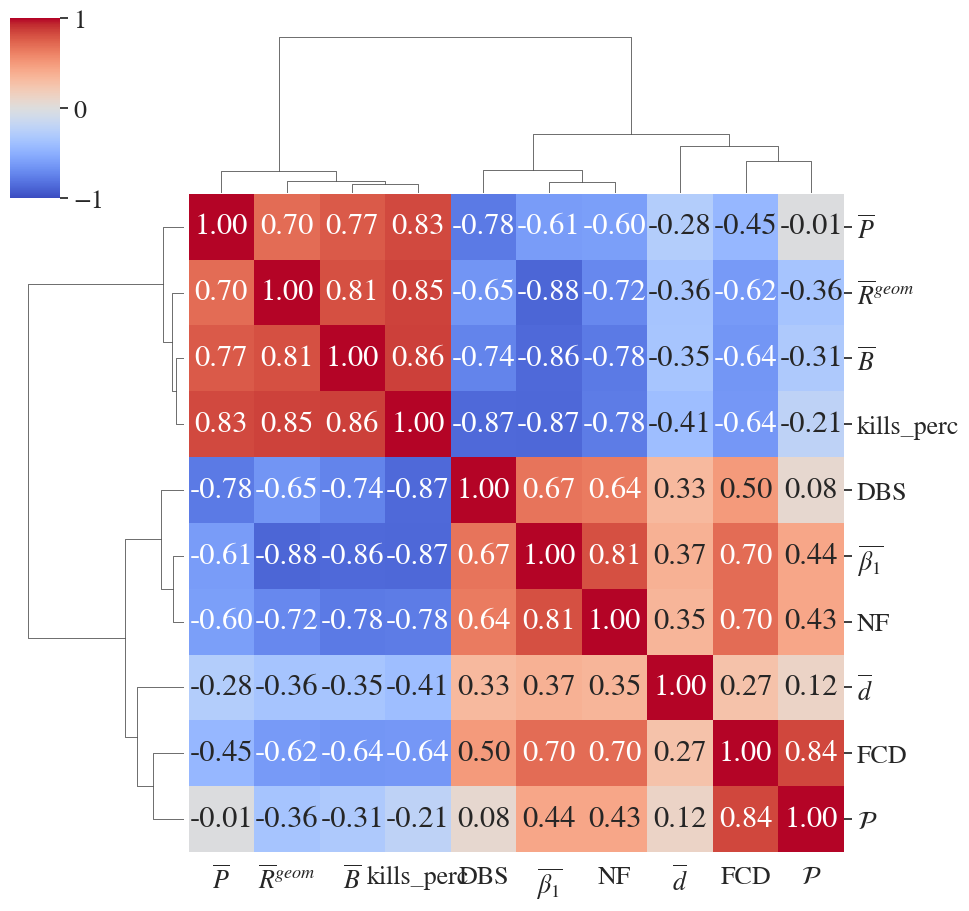

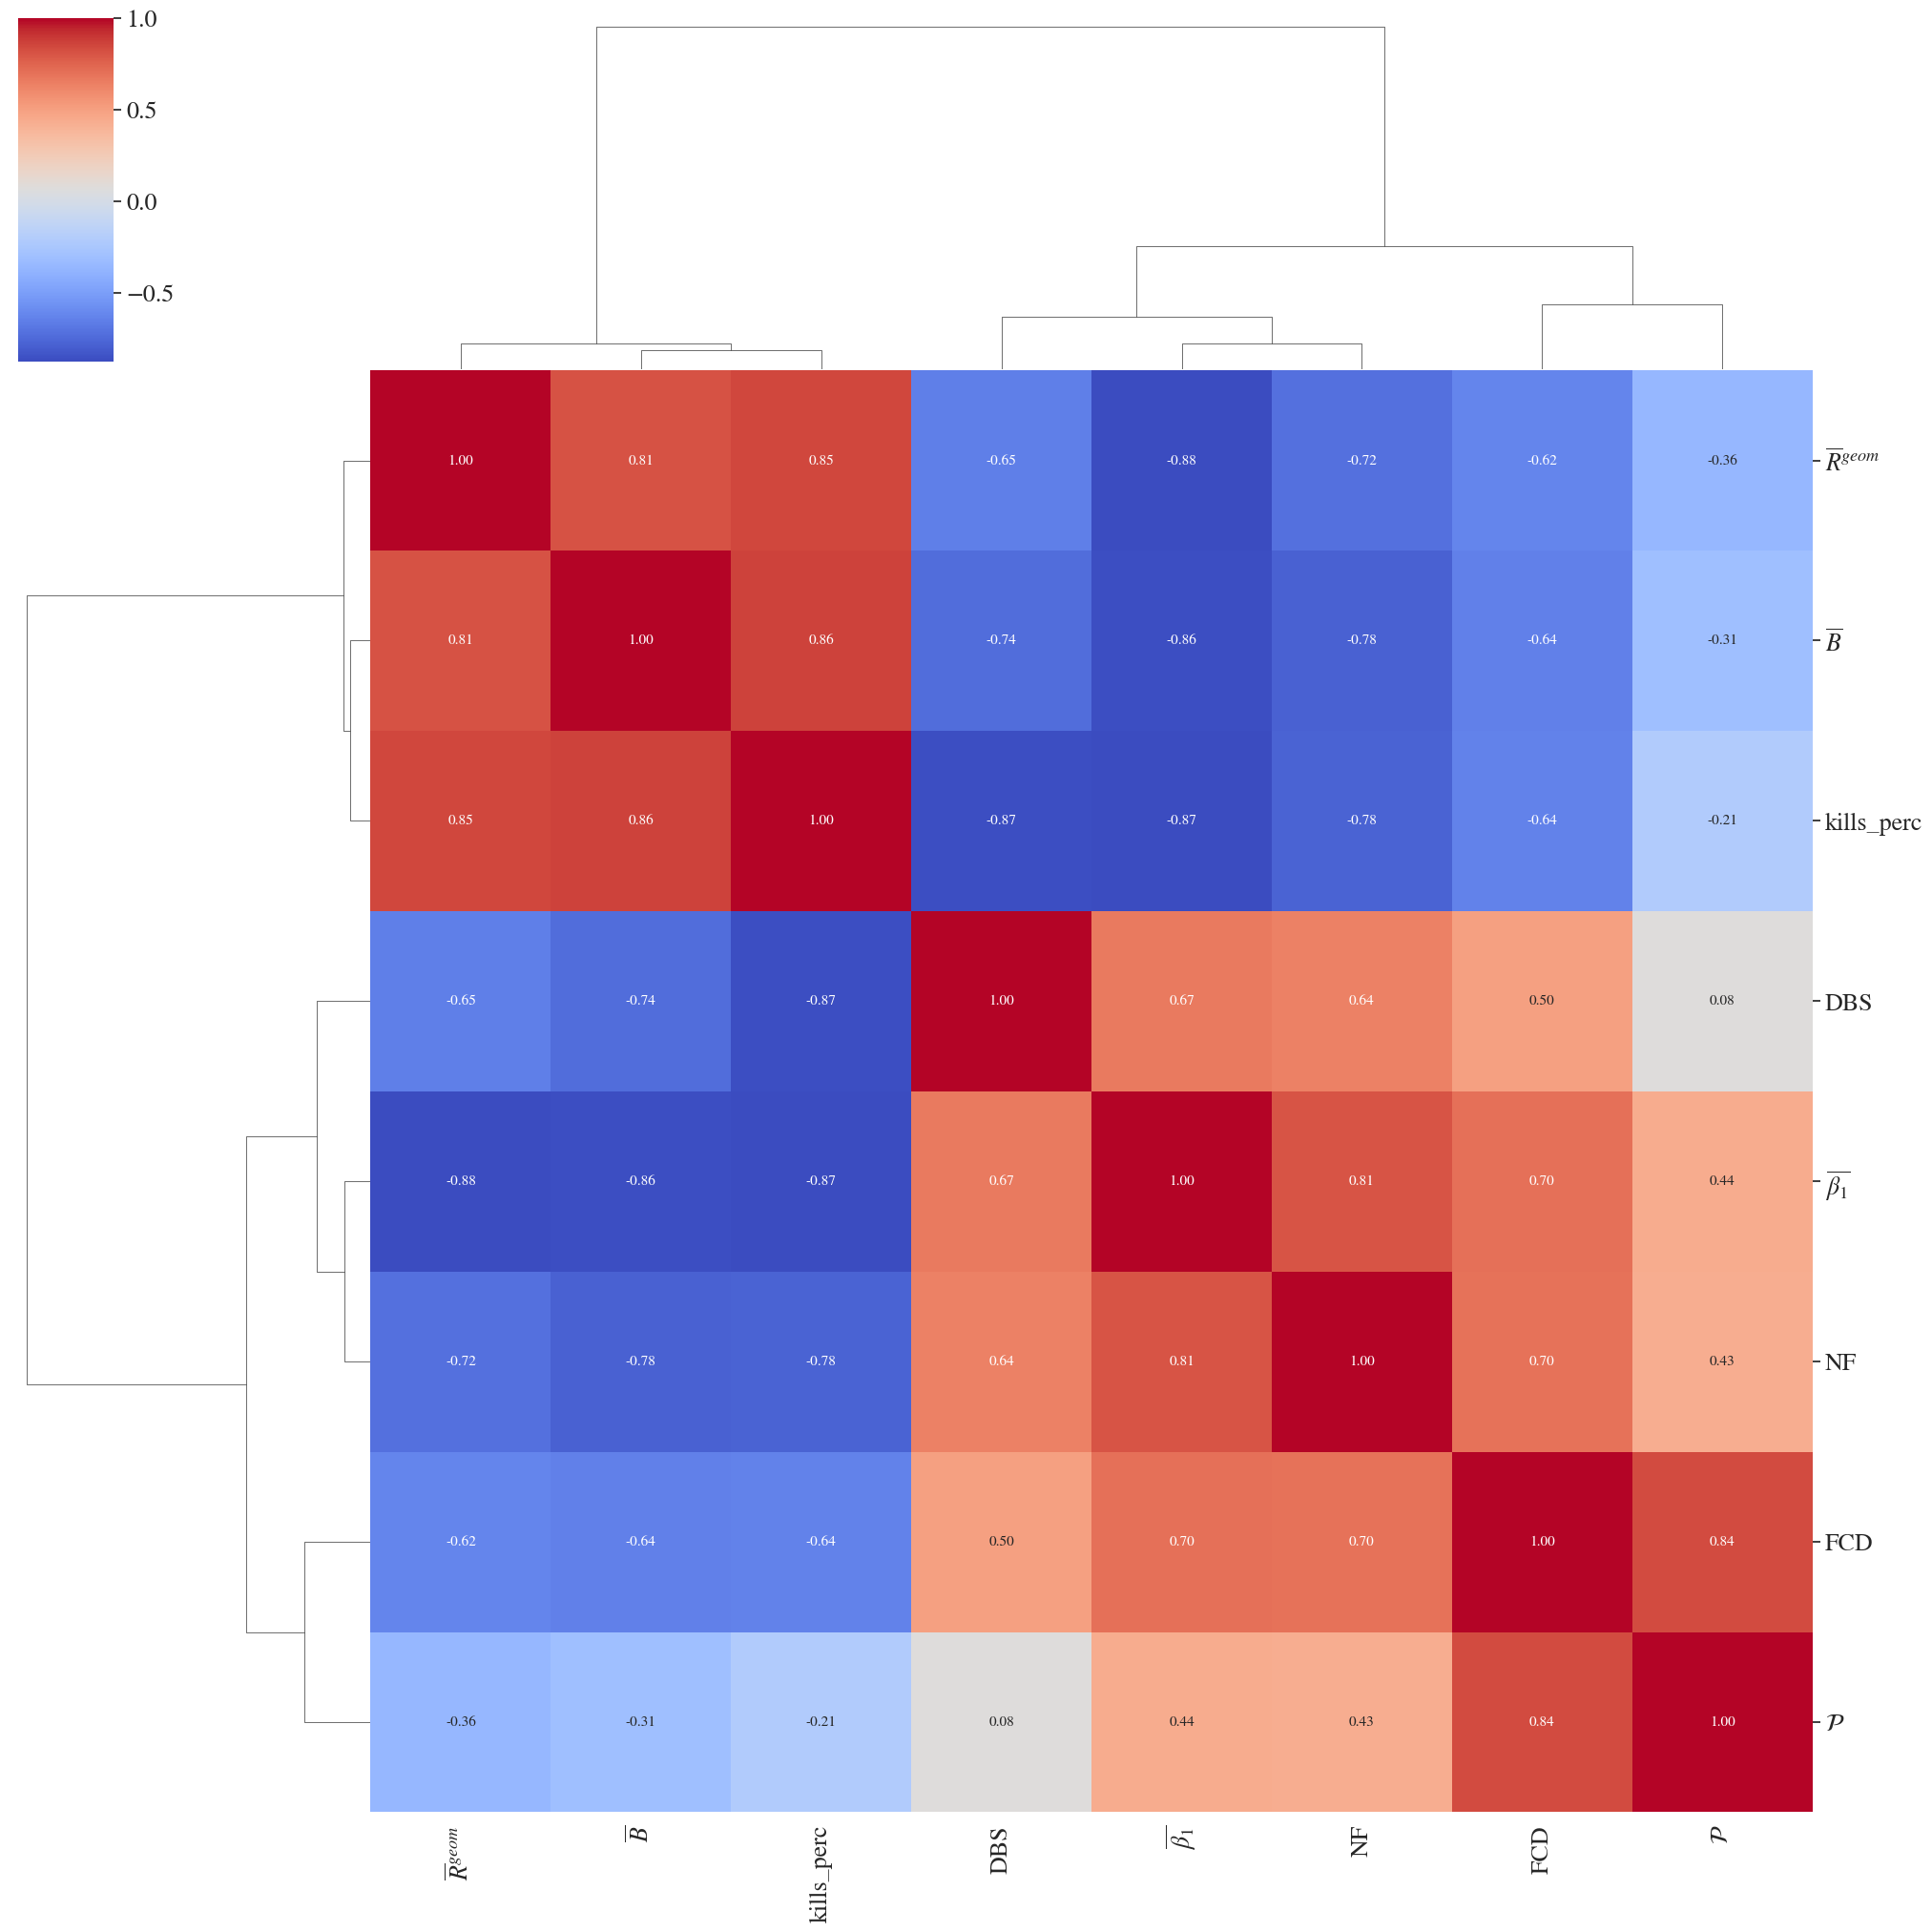

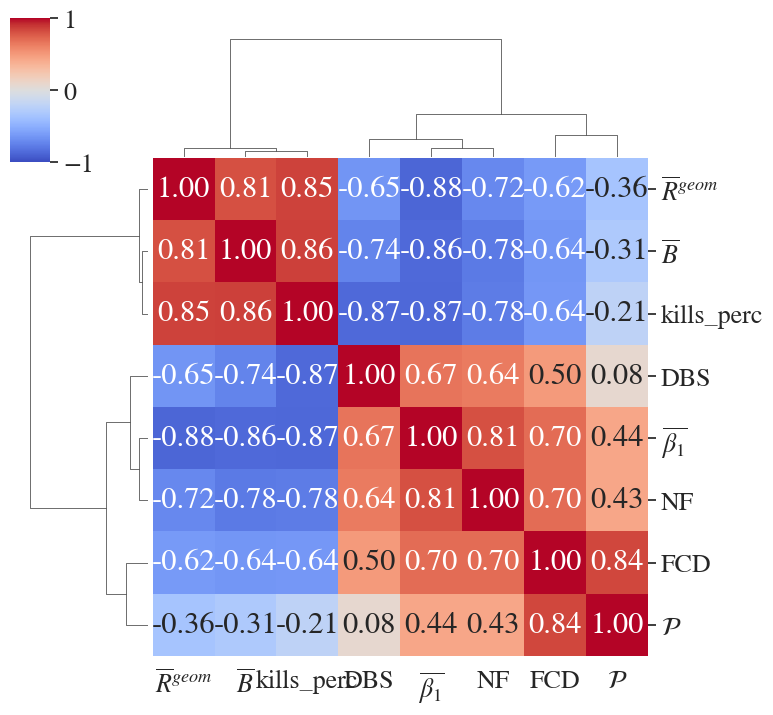

In [703]:
# Plot the correlation matrix
final_train = possible_train.copy()
correlation_matrix = final_train.corr(min_periods=1)
#sns.set(font_scale=0.7)

# Apply the replacement to both index and columns
new_index = [replace_label(label) for label in correlation_matrix.index]
new_columns = [replace_label(label) for label in correlation_matrix.columns]

# Create a new DataFrame with the updated labels
labeled_matrix = pd.DataFrame(
    correlation_matrix.values,
    index=new_index,
    columns=new_columns
)

# Now create the clustermap with the new labels
g = sns.clustermap(
    labeled_matrix, annot=True, cmap='coolwarm', metric="euclidean", 
    method='complete', annot_kws={"fontsize": 22}, fmt=".2f", figsize=(8, 8),
    vmin=-1, vmax=1  # Set the color scale limits
)

# Rotate the tick labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=0)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
# plt.tight_layout()  # Adjust the layout to prevent cutoff

# Save image
figure_title = 'clustermap'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches = 'tight')
plt.show()

Make a subset of the training data based on the features we just selected.

In [704]:
# Subset data based on feature selection
X_a = X[["FCD", "PPV", "VDi", "mean_geometric_resistance", 'loops/vessel', 'betweenness_unweighted_avg']]
Xa_train, Xa_test, ya_train, ya_test = train_test_split(X_a, Y, test_size=0.2, random_state=42)
ya_train = ya_train.values.ravel()  # Converts from (n_samples, 1) to (n_samples,)
ya_test = ya_test.values.ravel()  # Converts from (n_samples, 1) to (n_samples,)
# X_a = X
# Xa_train, Xa_test, ya_train, ya_test = X_train, X_test, y_train, y_test

# Record the simulations from which the test data is sourced
test_data_source = combined_df.loc[Xa_test.index, ['selection', 'kills','wouters_SF','lewin_SF']]

Let's take a peek at the features vs labels of interest.

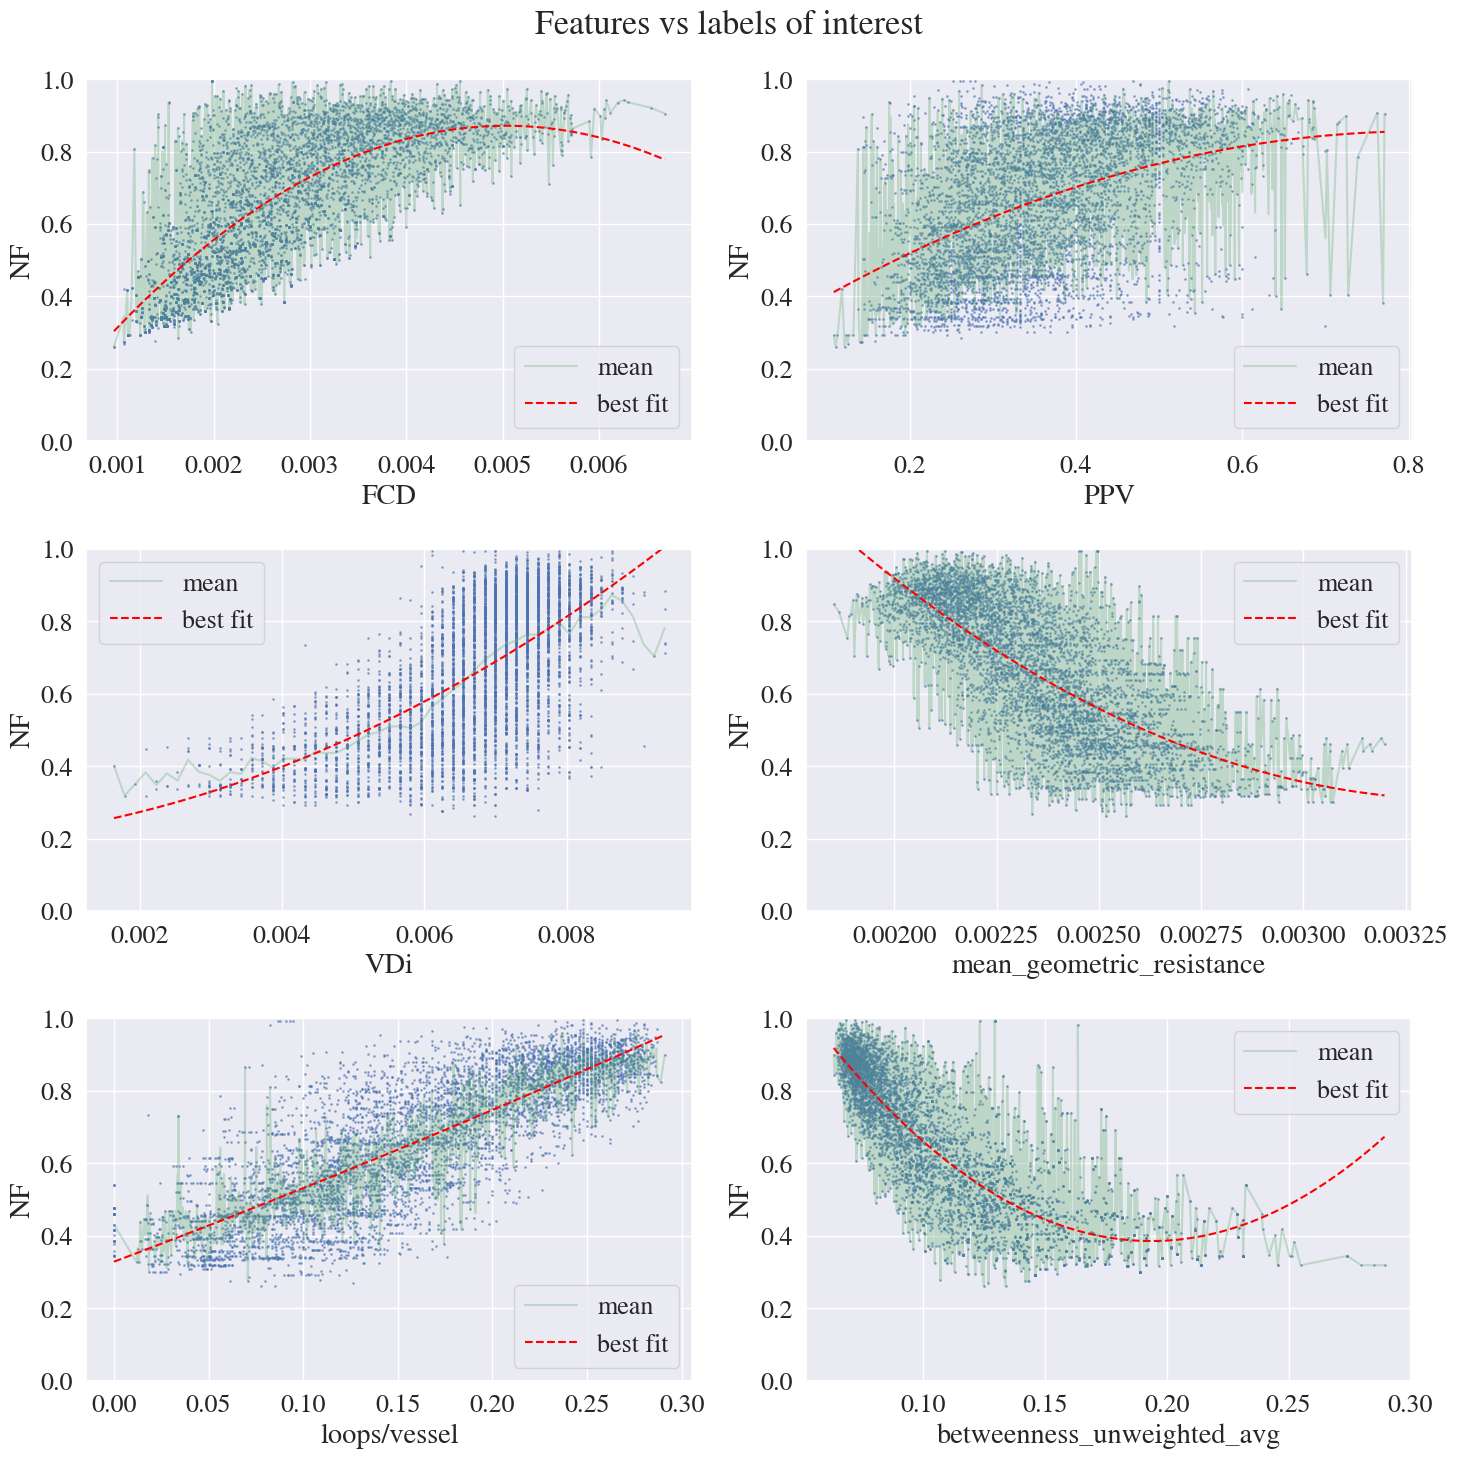

In [705]:
# Visualise features vs labels of interest
# '''
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
for i, feature in enumerate(Xa_test.columns):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.scatter(Xa_test[feature], ya_test, alpha=0.5, s=1)
    # ax.scatter(X_test[feature], predictions, color='red', alpha=0.5, label='Predicted (LR)')
    # ax.scatter(X_test[feature], predictions_rf, color='red', alpha=0.5, label='Predicted')
    # ax.set_title(f'{feature} vs NF')
    ax.set_xlabel(feature)
    ax.set_ylabel('NF')
    # ax.legend()
    # Calculate coefficients for the polynomial line of best fit (degree 2)
    coef = np.polyfit(Xa_test[feature], ya_test, 2)  # Change the degree here
    poly_fn = np.poly1d(coef)  # Create polynomial function
    # Create DataFrame from feature and Y_test for mean calculation
    throwaway = pd.DataFrame({feature: Xa_test[feature], 'ya_test': ya_test})
    
    # Calculate the mean of Y_test for each unique value of the feature
    means = throwaway.groupby(feature)['ya_test'].mean()

    # Plot the mean line
    ax.plot(means.index, means.values, color='g', alpha=0.3, label='mean')

    # Generate x values from the minimum to the maximum feature value for plotting
    x_fit = np.linspace(Xa_test[feature].min(), Xa_test[feature].max(), 100)
    y_fit = poly_fn(x_fit)
    # Find the x value of the maximum y value on the polynomial fit
    max_y_index = np.argmax(y_fit)
    max_y_value = y_fit[max_y_index]
    # Draw a vertical line from the maximum y-value to the y-axis
    # ax.axhline(y=max_y_value, color='blue', linestyle='--', label='Max Y Line')

    # Plot the line of best fit
    ax.plot(x_fit, y_fit, color='red', linestyle='--', label='best fit')
    ax.set_ylim(0,1)
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rectangle to make space for the suptitle
fig.suptitle('Features vs labels of interest')
plt.show()
# '''

## 5. Model selection

Pick the models we want to evaluate.

In [18]:
# Define models for evaluation
models = [
    ('LR', LinearRegression()), 
    ('R', Ridge()), 
    ('LASSO', Lasso()), 
    ('EN', ElasticNet()), 
    ('KN', KNeighborsRegressor()), 
    ('DTR', DecisionTreeRegressor(random_state=1)), 
    ('SVR', SVR(gamma='auto')),
    ('RF', RandomForestRegressor(random_state=1))
]

In [19]:
# Evaluate each model using 10-fold cross-validation
seed = 7
scoring = 'neg_mean_squared_error'
results, names = [], []
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

print("Model Evaluation Results:")
for name, model in models:
    cv_results = cross_val_score(model, Xa_train, ya_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name}: Mean MSE = {cv_results.mean():.4f} (Std = {cv_results.std():.4f})')

Model Evaluation Results:
LR: Mean MSE = -0.0051 (Std = 0.0001)
R: Mean MSE = -0.0081 (Std = 0.0001)
LASSO: Mean MSE = -0.0418 (Std = 0.0006)
EN: Mean MSE = -0.0418 (Std = 0.0006)
KN: Mean MSE = -0.0050 (Std = 0.0001)
DTR: Mean MSE = -0.0026 (Std = 0.0001)
SVR: Mean MSE = -0.0072 (Std = 0.0001)
RF: Mean MSE = -0.0013 (Std = 0.0000)


Plot the model comparison.

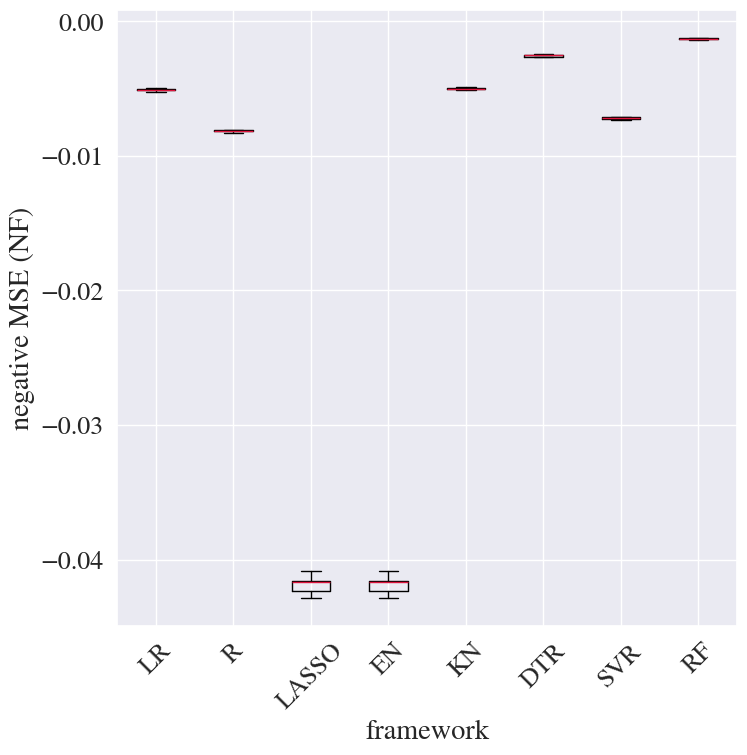

In [20]:
# Plot the comparison of model performance
plt.figure(figsize=(8, 8))
plt.boxplot(results, 
            boxprops=dict(color='black'),         # Box edges
            whiskerprops=dict(color='black'),     # Whisker lines
            capprops=dict(color='black'),         # Caps on whiskers
            medianprops=dict(color='crimson'),      # Median line
            # flierprops=dict(markeredgecolor='black'), 
            flierprops=dict(marker='None'),
            tick_labels=names  # Outliers
           )
plt.ylabel('negative MSE (NF)')
plt.xlabel('framework')
plt.xticks(rotation=45)
plt.show()

## 6. Evaluation of metrics

Define the best-performing model (RandomForest). Add cross-validation if needed but then I need to run multiple sets for RT too.

In [706]:
# Define a function to to use an RF algorithm to predict the NF using a set of features
def get_random_forest_error(feature):
    
    # Split the data into training and testing sets
    feature_train = Xa_train[feature]
    feature_test = Xa_test[feature]

    # Calculate how many unique values there are in each feature
    unique_counts = feature_train.nunique().sort_values()
    
    # Initialize the Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    model.fit(feature_train, ya_train)

    # Extract the feature importance
    feature_importance = pd.Series(model.feature_importances_, index=feature_train.columns)
    
    # Make predictions on the testing set
    predictions_rf = model.predict(feature_test)
    
    # Evaluate the model
    mse_rf = mean_squared_error(ya_test, predictions_rf)
    # print(f'Random Forest Mean Squared Error: {mse_rf}')

    return model, ya_test, predictions_rf, mse_rf, feature_importance, unique_counts


# # Function to evaluate Random Forest using cross-validation
# def evaluate_random_forest_with_cv(features, target, feature_subset=None, cv_folds=10, random_state=42):
#     """
#     Perform Random Forest regression with cross-validation.
    
#     Args:
#         features (pd.DataFrame): Input features.
#         target (pd.Series): Target variable.
#         feature_subset (list): Subset of features to use (default: use all features).
#         cv_folds (int): Number of CV folds.
#         random_state (int): Random seed for reproducibility.
        
#     Returns:
#         dict: Mean and std of cross-validated MSE, and feature importances.
#     """
#     # Use all features if no subset is specified
#     if feature_subset is None:
#         feature_subset = features.columns.tolist()
    
#     # Subset the data
#     X = features[feature_subset]
#     y = target

#     # Initialize the Random Forest Regressor
#     model = RandomForestRegressor(n_estimators=100, random_state=random_state)

#     # Perform K-fold cross-validation
#     kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
#     cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')

#     # Fit the model to the entire training set for feature importance
#     model.fit(X, y)
#     feature_importance = pd.Series(model.feature_importances_, index=feature_subset)
    
#     # Return results
#     return {
#         "mean_mse": -cv_results.mean(),
#         "std_mse": cv_results.std(),
#         "feature_importance": feature_importance
#     }

Categorise the metrics and train them all separately.

In [707]:
# Define the metric sets
wildcard = 'betweenness_unweighted_avg' 
geo_metrics = ['VDi', 'mean_geometric_resistance']
topo_metrics = ['loops/vessel', wildcard]
perf_metrics = ['PPV', 'FCD']
all_metrics = perf_metrics + geo_metrics + topo_metrics

# Get the test data, the predictions, and the error for individual metrics
model_ppv, truth_ppv, pred_ppv, ppv_error, _, _ = get_random_forest_error(['PPV'])
model_fcd, truth_fcd, pred_fcd, fcd_error, _, _ = get_random_forest_error(['FCD'])
model_vdi, truth_vdi, pred_vdi, vdi_error, _, _ = get_random_forest_error(['VDi'])
model_mgr, truth_mgr, pred_mgr, mgr_error, _, _ = get_random_forest_error(['mean_geometric_resistance'])
model_loops, truth_loops, pred_loops, loops_error, _, _ = get_random_forest_error(['loops/vessel'])
model_wildcard, truth_wildcard, pred_wildcard, wildcard_error, _, _ = get_random_forest_error([wildcard])

# Get the categorical accuracy
model_perf, truth_perf, pred_perf, perf_error, perf_feature_importance, _ = get_random_forest_error(perf_metrics)
model_geo, truth_geo, pred_geo, geo_error, geo_feature_importance, _ = get_random_forest_error(geo_metrics)
model_topo, truth_topo, pred_topo, topo_error, topo_feature_importance, unique_counts = get_random_forest_error(topo_metrics)
model_all, truth_all, pred_all, all_error, all_feature_importance, unique_counts = get_random_forest_error(all_metrics)

# Pair the data and customise the labels
data_pairs = [
    (truth_ppv, pred_ppv, r'$\mathcal{P}$'),
    (truth_fcd, pred_fcd, "FCD"),
    (truth_vdi, pred_vdi, "DBS"),
    (truth_mgr, pred_mgr, r'$\overline{R}^{geom}$'),
    (truth_wildcard, pred_wildcard, r'$\overline{B}$'),
    (truth_loops, pred_loops, r'$\overline{β_1}$'),
    (truth_perf, pred_perf, "all perfusion"),
    (truth_geo, pred_geo, "all geometrical"),
    (truth_topo, pred_topo, "all topological"),
    (truth_all, pred_all, "all")
]  

Let's visualise the fit.

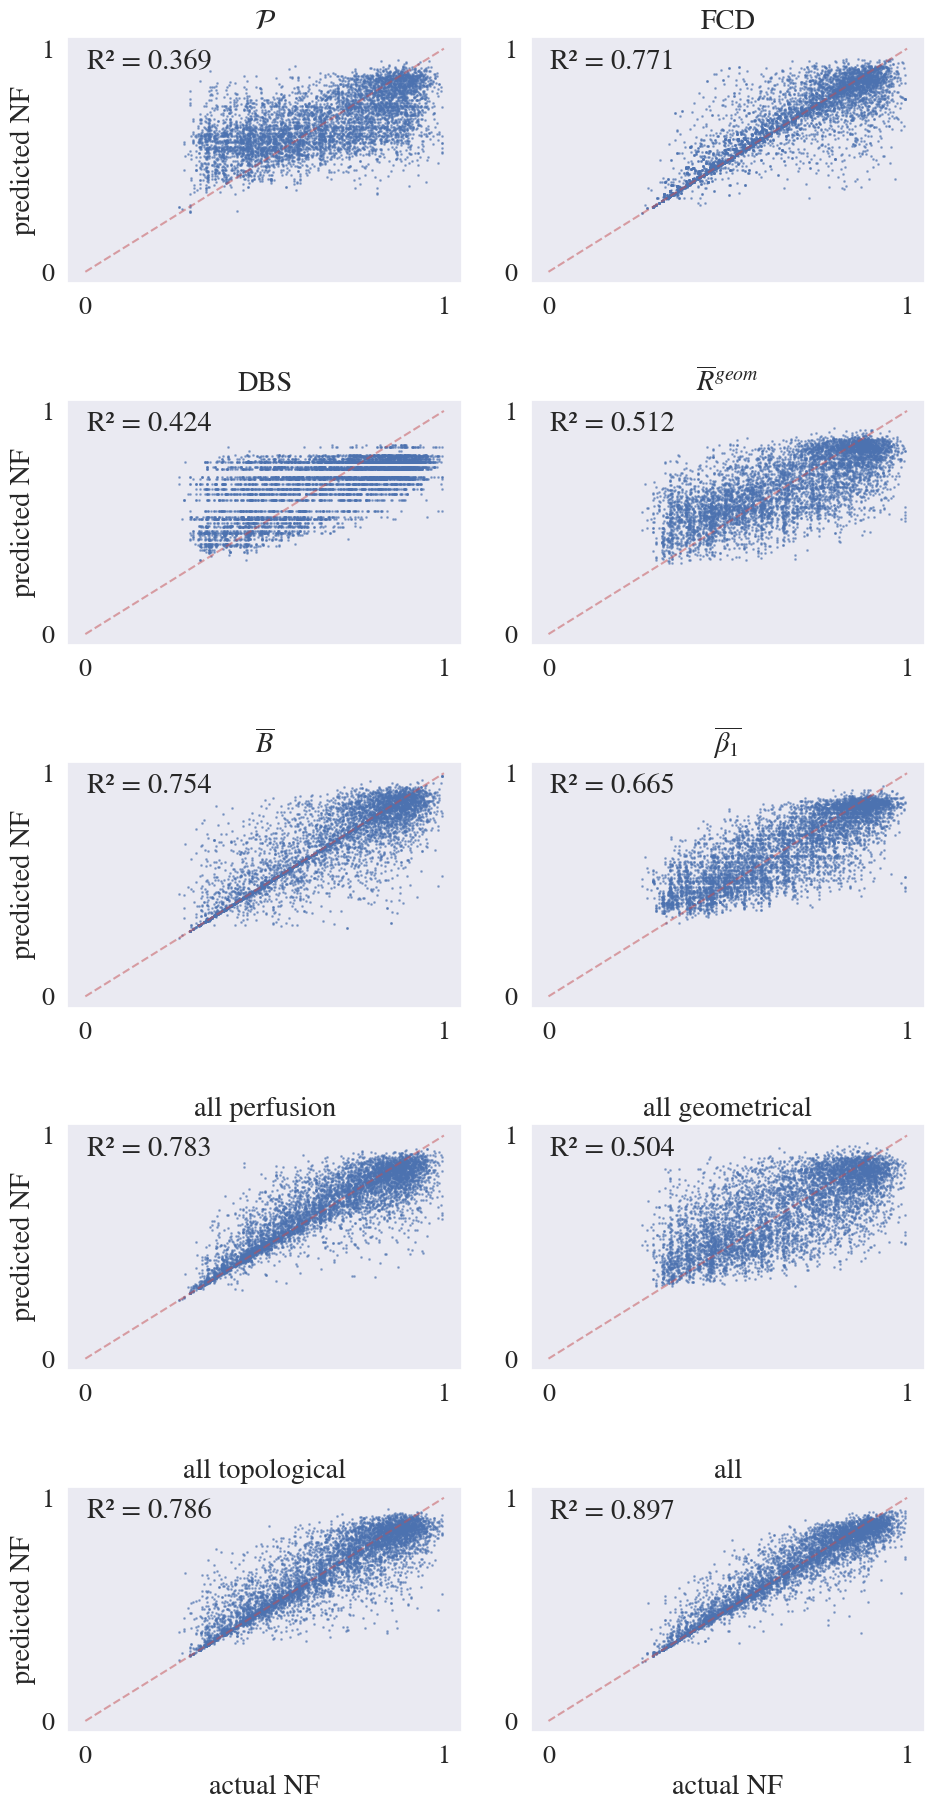

In [708]:
# Plot the R-square values
fig, axs = plt.subplots(5, 2, figsize=(10, 25 * 0.75))
axs = axs.flatten()

for i, (truth, pred, title) in enumerate(data_pairs):
    axs[i].scatter(truth, pred, alpha=0.5, s=1)
    axs[i].set_title(title)

    # Set labels based on position
    # Remove y-label for plots in the second column
    if i % 2 == 0:
        axs[i].set_ylabel("predicted NF")
    if i >= 8:
        axs[i].set_xlabel("actual NF")

    # Remove the grid lines
    axs[i].grid(False)

    # Add a diagonal line
    min_val = 0
    max_val = 1
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

    # Set tick format to be consistent and without decimals
    axs[i].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5, integer=True))
    axs[i].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5, integer=True))

    # Calculate and display R-squared
    correlation_matrix_rf = np.corrcoef(truth.flatten(), pred.flatten())
    r_squared = correlation_matrix_rf[0, 1]**2
    axs[i].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axs[i].transAxes, 
                verticalalignment='top')

plt.tight_layout(pad=1.5, h_pad=1.5)

# Save image
figure_title = 'r_squared'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()


Let's check the MSEs.

In [709]:
# Plot a bar chart of the different errors
copied_array = np.copy(Y_test)
copied_array[:] = np.mean(Y_train)
mean_error = mean_squared_error(Y_test,copied_array)  # use the mean of the training NF as a benchmark for comparison
values = [ppv_error, fcd_error, vdi_error, mgr_error, wildcard_error, loops_error, perf_error, geo_error, topo_error, all_error]
labels = [r'$\mathcal{P}$', 'FCD', 'DBS', r'$\overline{R}^{geom}$', r'$\overline{B}$', r'$\overline{β_1}$', 'all perfusion', 'all geometrical', "all topological", 'all']
plt.figure(figsize=(8, 8))
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=45, ha='right')
# plt.ylim(0, 0.012)
plt.xlabel('metric')
plt.ylabel('MSE (NF)')
# plt.title('Algorithm errors')
# plt.grid()
# plt.show()

# Save image
figure_title = 'mse'
# file_path = Path(figure_folder + figure_title + '.svg').expanduser()
# plt.savefig(file_path, dpi=500, bbox_inches = 'tight')
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches = 'tight')

We can also check the feature importance.

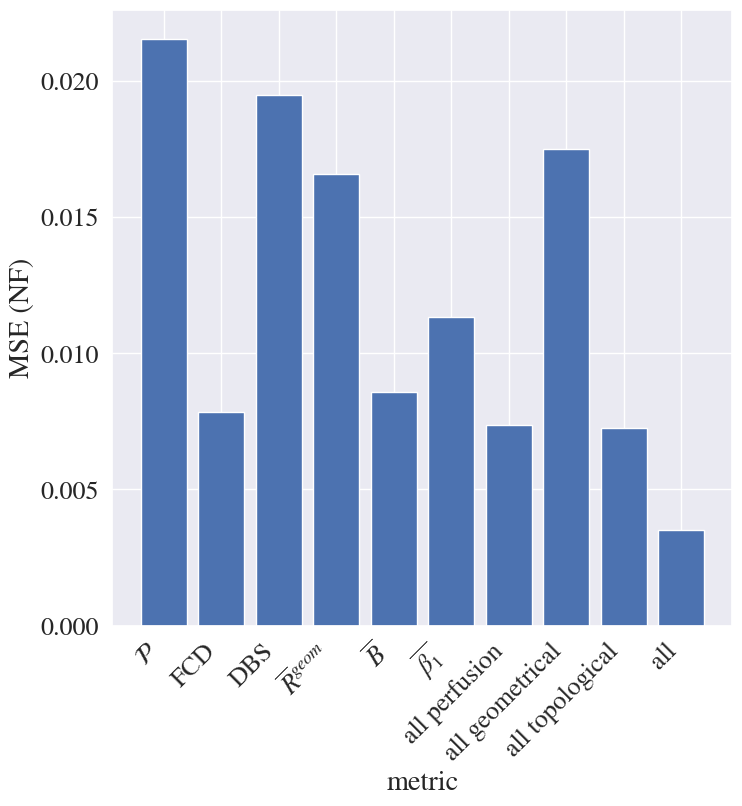

<Figure size 1000x1000 with 0 Axes>

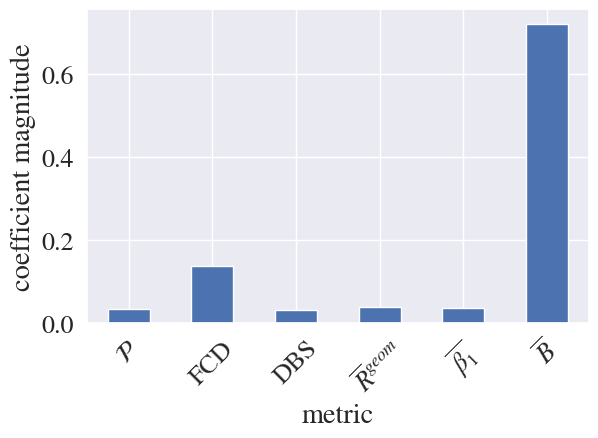

In [710]:
# Plotting unique counts
plt.figure(figsize=(10, 10))
'''
plt.subplot(1, 2, 1)
unique_counts.plot(kind='bar')
plt.title('Number of Unique Values per Feature')
plt.ylabel('Unique Values Count')
plt.xlabel('Features')

# Plotting Feature Importance vs Unique Counts
plt.subplot(1, 2, 2)
'''

# Apply the replacement to both index and columns
new_index = [replace_label(label) for label in all_feature_importance.index]
# new_columns = [replace_label(label) for label in all_feature_importance.columns]

# Create a new DataFrame with the updated labels
labeled_matrix = pd.DataFrame(
    all_feature_importance.values,
    index=new_index
)

labeled_matrix.plot(kind='bar', legend=False)
# plt.title('Feature importance vs. unique Values')
# plt.xlabel('Unique Values Count')
# plt.ylim(0,0.7)
# plt.ylabel('weight')
plt.ylabel('coefficient magnitude')
plt.xticks(rotation=45)
plt.xlabel('metric')
plt.tight_layout()
# plt.title('Feature importance for RF')
figure_title = 'feature_importance'
# file_path = Path(figure_folder + figure_title + '.svg').expanduser()
# plt.savefig(file_path, dpi=500, bbox_inches = 'tight')
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500)

plt.show()


     Actual  Predicted     Error
0  0.494737   0.492745  0.001992
1  0.911201   0.892413  0.018788
2  0.952227   0.823798  0.128429
3  0.368421   0.367887  0.000534
4  0.343590   0.343269  0.000321
5  0.633198   0.628316  0.004883
6  0.465317   0.478748 -0.013430
7  0.439136   0.469924 -0.030788
8  0.523887   0.559474 -0.035587
9  0.562753   0.537768  0.024985


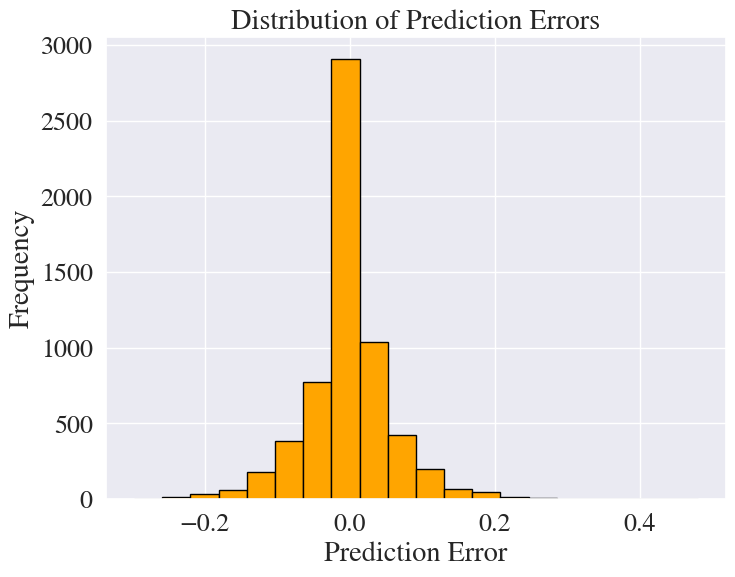

In [711]:
# Comparison Table
results_df = pd.DataFrame({'Actual': truth_all, 'Predicted': pred_all})
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
print(results_df.head(10))  # Display the first 10 results

# Histogram of Prediction Errors
plt.figure(figsize=(8, 6))
plt.hist(results_df['Error'], bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

We can quantify the percentage improvement.

In [712]:
# Print percentage difference between arch and perf metrics 
'''
def calculate_accuracy_improvement(mse1, mse2, best_mse):
    """
    Calculates how much more accurate mse1 is compared to mse2 when compared to the best MSE.

    Parameters:
    - mse1: The first MSE.
    - mse2: The second MSE.
    - best_mse: The best MSE.

    Returns:
    - improvement_percentage: Percentage improvement of mse1 over mse2 relative to best_mse.
    """
    # Calculate absolute differences from best_mse
    diff1 = mse1 - best_mse
    diff2 = mse2 - best_mse

    # Ensure we are comparing improvements correctly
    if diff2 == 0:
        improvement_percentage = float('inf')  # Avoid division by zero
    else:
        # Calculate the percentage improvement
        improvement_percentage = ((diff2 - diff1) / diff2) * 100

    return improvement_percentage

# Example usage
mse1 = arch_error
mse2 = perf_error
best_mse = all_error

improvement = calculate_accuracy_improvement(mse1, mse2, best_mse)

print(f"mse1 is {improvement:.2f}% more accurate than mse2 when compared to best_mse.")
'''


'\ndef calculate_accuracy_improvement(mse1, mse2, best_mse):\n    """\n    Calculates how much more accurate mse1 is compared to mse2 when compared to the best MSE.\n\n    Parameters:\n    - mse1: The first MSE.\n    - mse2: The second MSE.\n    - best_mse: The best MSE.\n\n    Returns:\n    - improvement_percentage: Percentage improvement of mse1 over mse2 relative to best_mse.\n    """\n    # Calculate absolute differences from best_mse\n    diff1 = mse1 - best_mse\n    diff2 = mse2 - best_mse\n\n    # Ensure we are comparing improvements correctly\n    if diff2 == 0:\n        improvement_percentage = float(\'inf\')  # Avoid division by zero\n    else:\n        # Calculate the percentage improvement\n        improvement_percentage = ((diff2 - diff1) / diff2) * 100\n\n    return improvement_percentage\n\n# Example usage\nmse1 = arch_error\nmse2 = perf_error\nbest_mse = all_error\n\nimprovement = calculate_accuracy_improvement(mse1, mse2, best_mse)\n\nprint(f"mse1 is {improvement:.2f}%

Here's a quick and dirty way to find some visual examples for the topological metrics.

In [713]:
# Find the row with the highest betweenness_unweighted_avg
# combined_df = combined_df[combined_df['size_largest_connected_component'] == 70]  # control for the SoLCC
max_bw_row = combined_df.loc[combined_df['betweenness_unweighted_avg'].idxmax()]
min_bw_row = combined_df.loc[combined_df['betweenness_unweighted_avg'].idxmin()]
max_selection_kill = max_bw_row[['selection', 'kills']]
min_selection_kill = min_bw_row[['selection', 'kills']]
print(f"Highest betweenness_unweighted_avg: \n{max_selection_kill}")
print(f"Lowest betweenness_unweighted_avg: \n{min_selection_kill}")

Highest betweenness_unweighted_avg: 
selection     73.0
kills        104.0
Name: 2701, dtype: float64
Lowest betweenness_unweighted_avg: 
selection    424.0
kills          0.0
Name: 17171, dtype: float64


## 7. Export data for next Chapter

Export the data for the RT study.

In [30]:
# Create the prediction DataFrame from the data_pairs
NF_pred = {
    "selection": test_data_source['selection'],
    "kills": test_data_source['kills'],
    "wouters_SF": test_data_source['wouters_SF'],
    "lewin_SF": test_data_source['lewin_SF'],
    "PPV": pred_ppv,
    "FCD": pred_fcd,
    "DBS": pred_vdi,
    "mean_geometric_resistance": pred_mgr,
    "wildcard": pred_wildcard,
    "beta_1": pred_loops,
    "all perfusion": pred_perf,
    "all geometrical": pred_geo,
    "all topological": pred_topo,
    "all": pred_all
}
NF_pred_df = pd.DataFrame(NF_pred)
NF_pred_df['truth'] = truth_all
NF_pred_df_hdf5_path = simulation_path + '/predictions.h5'  # Change this to your desired file path
NF_pred_df.to_hdf(NF_pred_df_hdf5_path, key='predictions', mode='w', format='table')

## 8. Predict the biological network.

Finally, we can make demo predictions for the biological networks.

In [747]:
# Input data for biological network (H=0.3, lectin)
# true_NF = 0.9895
# true_NF = 0.5020
true_NF = 0.98311
new_data = {
    'PPV': [0.9720],
    'VDi': [0.03046],
    'mean_geometric_resistance': [0.0003701],
    'FCD': [0.04276],
    'loops/vessel': [0.2581],
    'betweenness_unweighted_avg': [0.01494]
    # 'loops/vessel': [0.1215],
    # 'betweenness_unweighted_avg': [0.022]
}

# Convert to DataFrame with the correct feature names
new_data_df = pd.DataFrame(new_data)

# Make predictions
new_pred_perf = model_perf.predict(new_data_df[perf_metrics])
new_pred_geo = model_geo.predict(new_data_df[geo_metrics])
new_pred_topo = model_topo.predict(new_data_df[topo_metrics])

# Calculate RMSE for each prediction category
rmse_perf = ((true_NF - new_pred_perf[0]) ** 2) ** 0.5
rmse_geo = ((true_NF - new_pred_geo[0]) ** 2) ** 0.5
rmse_topo = ((true_NF - new_pred_topo[0]) ** 2) ** 0.5

# Print predictions and RMSE values
print(f"Perfusion Metrics Prediction: {new_pred_perf[0]} (RMSE: {rmse_perf:.4f})")
print(f"Geometrical Metrics Prediction: {new_pred_geo[0]} (RMSE: {rmse_geo:.4f})")
print(f"Topological Metrics Prediction: {new_pred_topo[0]} (RMSE: {rmse_topo:.4f})")

Perfusion Metrics Prediction: 0.8982375168690965 (RMSE: 0.0849)
Geometrical Metrics Prediction: 0.8578677462887988 (RMSE: 0.1252)
Topological Metrics Prediction: 0.9144885290148443 (RMSE: 0.0686)


In [753]:
new_pred_perf= 0.9238785425101226 
new_pred_geo= 0.8100701754385973 
new_pred_topo= 0.8987179487179485 

new_pred_perf= 0.8982375168690965 
new_pred_geo= 0.8578677462887988 
new_pred_topo= 0.9144885290148443 

# Calculate RMSE for each prediction category
rmse_perf = ((true_NF - new_pred_perf) ** 2) ** 0.5
rmse_geo = ((true_NF - new_pred_geo) ** 2) ** 0.5
rmse_topo = ((true_NF - new_pred_topo) ** 2) ** 0.5

# Print predictions and RMSE values
print(f"Perfusion Metrics Prediction: {new_pred_perf} (RMSE: {rmse_perf:.4f})")
print(f"Geometrical Metrics Prediction: {new_pred_geo} (RMSE: {rmse_geo:.4f})")
print(f"Topological Metrics Prediction: {new_pred_topo} (RMSE: {rmse_topo:.4f})")

Perfusion Metrics Prediction: 0.8982375168690965 (RMSE: 0.0849)
Geometrical Metrics Prediction: 0.8578677462887988 (RMSE: 0.1252)
Topological Metrics Prediction: 0.9144885290148443 (RMSE: 0.0686)


Plot the RMSE for each set for H=0.3.

In [ ]:
# Voronoi-size
# Perfusion Metrics Prediction: 0.9238785425101226 (RMSE: 0.0656)
# Geometrical Metrics Prediction: 0.8100701754385973 (RMSE: 0.1794)
# Topological Metrics Prediction: 0.8987179487179485 (RMSE: 0.0908)

# # Voronoi flow
# Perfusion Metrics Prediction: 0.8982375168690965 (RMSE: 0.0913)
# Geometrical Metrics Prediction: 0.8578677462887988 (RMSE: 0.1316)
# Topological Metrics Prediction: 0.9144885290148443 (RMSE: 0.0750)

# Ensure LaTeX-style font globally
sns.reset_orig()
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

# Data for plotting (H=0.3)
categories = ['perfusion', 'geometrical', 'topological']
# rmse_voronoi_size = [0.0656, 0.1794, 0.0908]  # RMSE for Voronoi-size
# rmse_voronoi_flow = [0.0913, 0.1316, 0.0750]  # RMSE for Voronoi-flow

# Data for H=0.1
rmse_voronoi_size = [0.0592, 0.1730, 0.0844]  # RMSE for Voronoi-flow
rmse_voronoi_flow = [0.0849, 0.1252, 0.0686]  # RMSE for Voronoi-flow

# Data for H=0.07... 
# rmse_voronoi_size = [0.4219, 0.3081, 0.3967]  # RMSE for Voronoi-flow
# rmse_voronoi_flow = [0.3962, 0.3559, 0.4125]  # RMSE for Voronoi-flow

# Plot
x = range(len(categories))  # Positions for the bars
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.15  # Width of the bars

# Plot RMSE bars
colors = ['#0072B2', '#009E73','crimson']
ax.bar([pos - width/2 for pos in x], rmse_voronoi_size, width, label='size', color=colors[2], edgecolor='black', linewidth=2)
ax.bar([pos + width/2 for pos in x], rmse_voronoi_flow, width, label='flow', color=colors[1], edgecolor='black', linewidth=2)

# Customise plot
ax.set_xlabel('metrics')
ax.set_ylabel('RMSE (NF)')
# ax.set_title('RMSE Comparison Across Categories')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Remove top spine
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save and show the plot
plt.tight_layout()
figure_title = 'RMSE_NF'
file_path = Path(figure_folder + figure_title + '.png').expanduser()
plt.savefig(file_path, dpi=500, bbox_inches='tight')
plt.show()

In [716]:
# Input data for biological network (H=0.3, lectin)
true_NF = 0.5020
new_data = {
    'PPV': [0.9720],
    'VDi': [0.03046],
    'mean_geometric_resistance': [0.0003701],
    'FCD': [0.04276],
    'loops/vessel': [0.2581],
    'betweenness_unweighted_avg': [0.01494]
    # 'loops/vessel': [0.1215],
    # 'betweenness_unweighted_avg': [0.022]
}

# Convert to DataFrame with the correct feature names
new_data_df = pd.DataFrame(new_data)

# Make predictions
new_pred_perf = model_perf.predict(new_data_df[perf_metrics])
print(f"Perfusion Metrics Prediction: {new_pred_perf[0]}")
new_pred_geo = model_geo.predict(new_data_df[geo_metrics])
print(f"Geometrical Metrics Prediction: {new_pred_geo[0]}")
new_pred_topo = model_topo.predict(new_data_df[topo_metrics])
print(f"Topological Metrics Prediction: {new_pred_topo[0]}")

Perfusion Metrics Prediction: 0.8982375168690965
Geometrical Metrics Prediction: 0.8578677462887988
Topological Metrics Prediction: 0.9144885290148443
